In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pypsa

In [2]:
plt.rcParams.update({'font.size': 18})

def get_time_index(year):
    t = pd.date_range('%d-01-01 00:00'%year, '%d-12-31 23:00'%year, freq = 'H')
    if (year%100 != 0 and year%4 == 0) or year%400 == 0: # leap year
        t = t[:1416].union(t[1440:]) # drop 2/29 due to lack of data
    return t

# weather data from refinement
def get_capacity_factor(t,lat_lon):
    cf = pd.DataFrame(index = t, columns = ['Wind','PV'])
    cf.Wind = pd.read_csv('data/cf/wind_%s.csv'%lat_lon, index_col = 0).to_numpy()
    cf.PV = pd.read_csv('data/cf/pv_%s.csv'%lat_lon, index_col = 0).to_numpy()
    return cf

def fast_fourier_transform(cf,fs): # pandas series of capacity factor, sampling rate
    y = cf.values # array
    N = y.size # sampling points amount
    dt = 1/fs # sampling period
    xf = np.fft.rfftfreq(N, dt) # frequency
    yf = np.fft.rfft(y) # intensity
    ym = 2/N*abs(yf) # amplitude normalization
    ym[0] = ym[0]/2 # amplitude normalization
    return xf, yf, ym

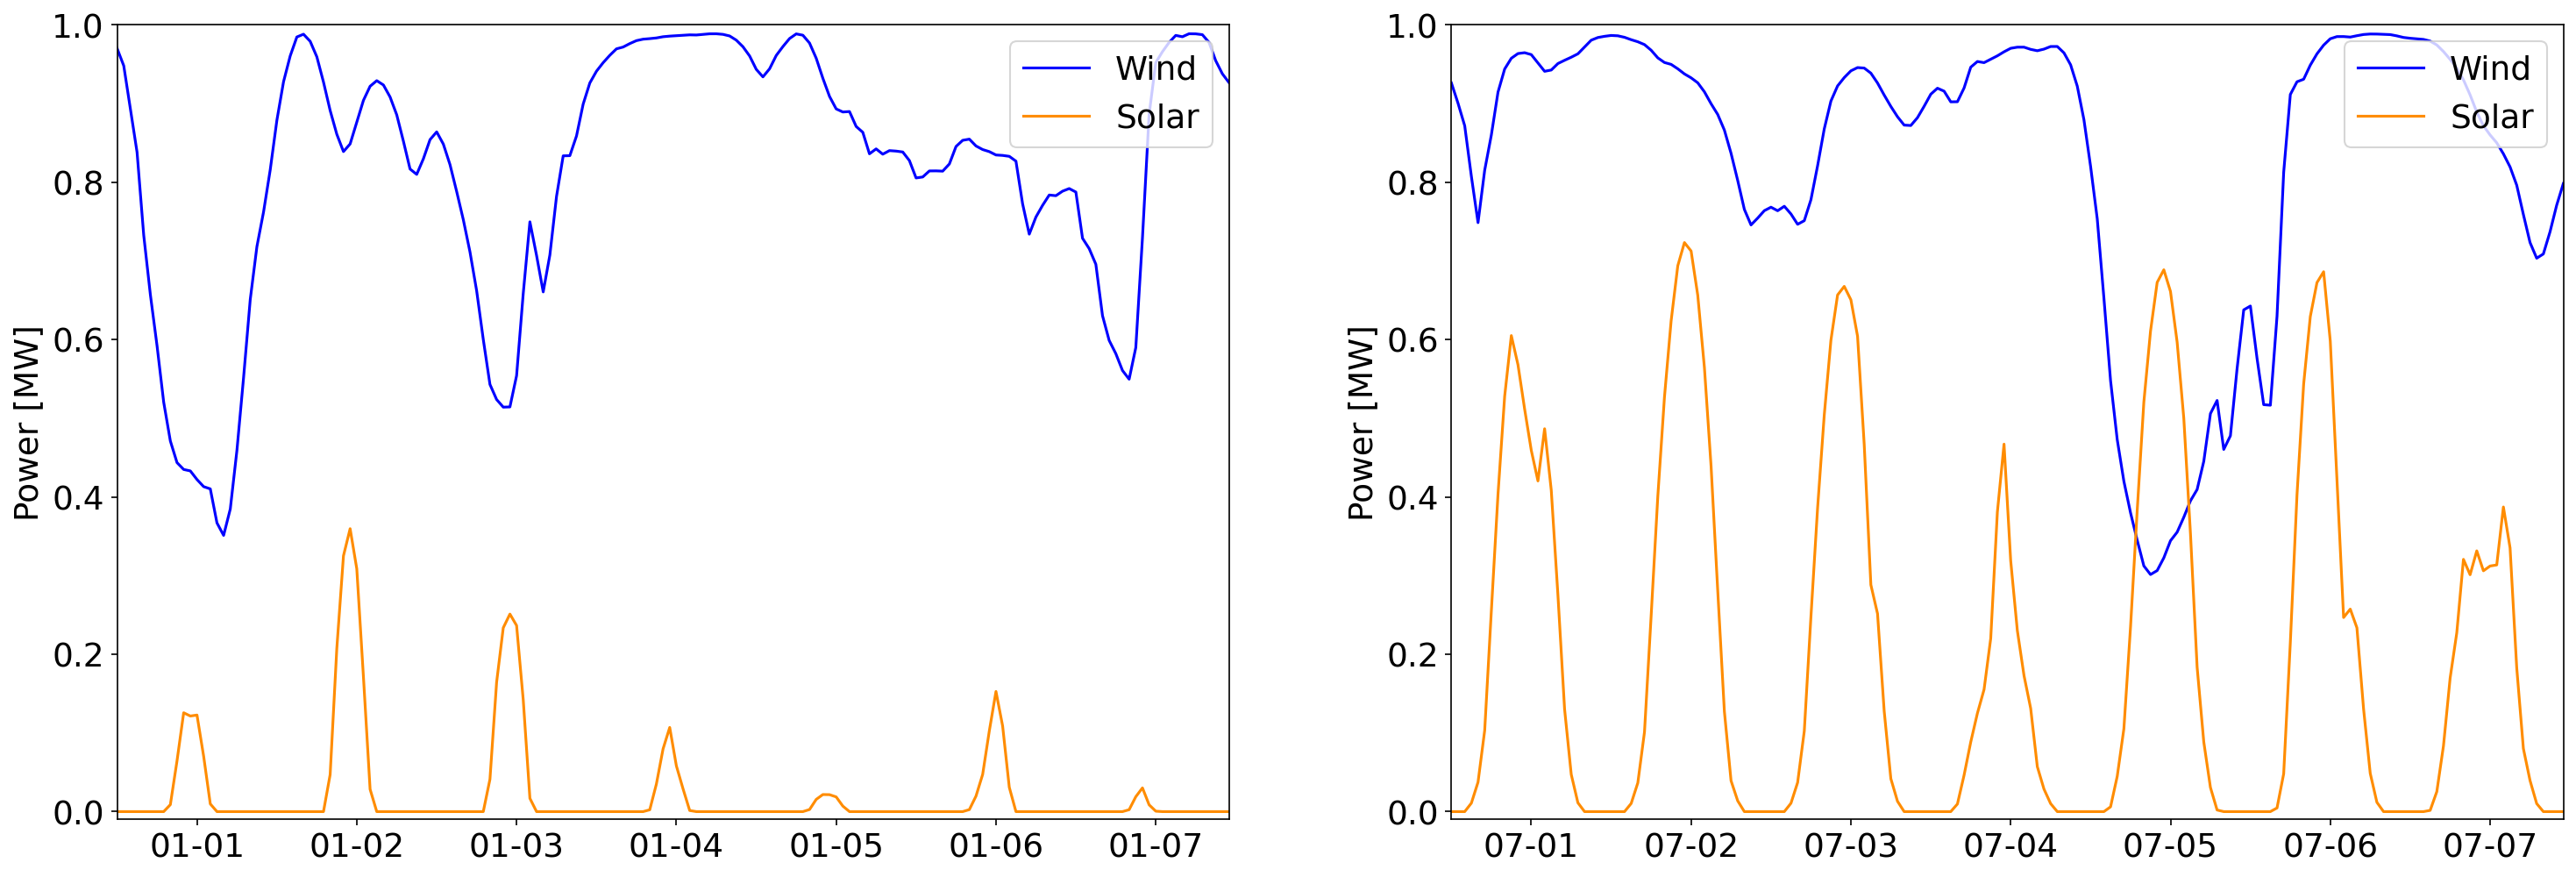

In [3]:
t = get_time_index(2030) # sample: 2030
cf = get_capacity_factor(t,'56.4000_6.8000') # sample: energy island

# weather data slice
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (24,8), dpi = 150)
ax1.plot(cf['Wind']['2030-01-01 00:00':'2030-01-07 23:00'], c = 'blue', label = 'Wind')
ax1.plot(cf['PV']['2030-01-01 00:00':'2030-01-07 23:00'], c = 'darkorange', label = 'Solar')
ax1.set_xticks(['2030-01-0%s 12:00'%i for i in range(1,8)])
ax1.set_xticklabels(['01-0%s'%i for i in range(1,8)])
ax1.set_xlim('2030-01-01 00:00','2030-01-07 23:00')
ax1.set_ylabel('Power [MW]')
ax1.set_ylim(-0.01, 1)
ax1.legend(loc = 'upper right')

ax2.plot(cf['Wind']['2030-07-01 00:00':'2030-07-07 23:00'], c = 'blue', label = 'Wind')
ax2.plot(cf['PV']['2030-07-01 00:00':'2030-07-07 23:00'], c = 'darkorange', label = 'Solar')
ax2.set_xticks(['2030-07-0%s 12:00'%i for i in range(1,8)])
ax2.set_xticklabels(['07-0%s'%i for i in range(1,8)])
ax2.set_xlim('2030-07-01 00:00','2030-07-07 23:00')
ax2.set_ylabel('Power [MW]')
ax2.set_ylim(-0.01, 1)
ax2.legend(loc = 'upper right')
plt.show()

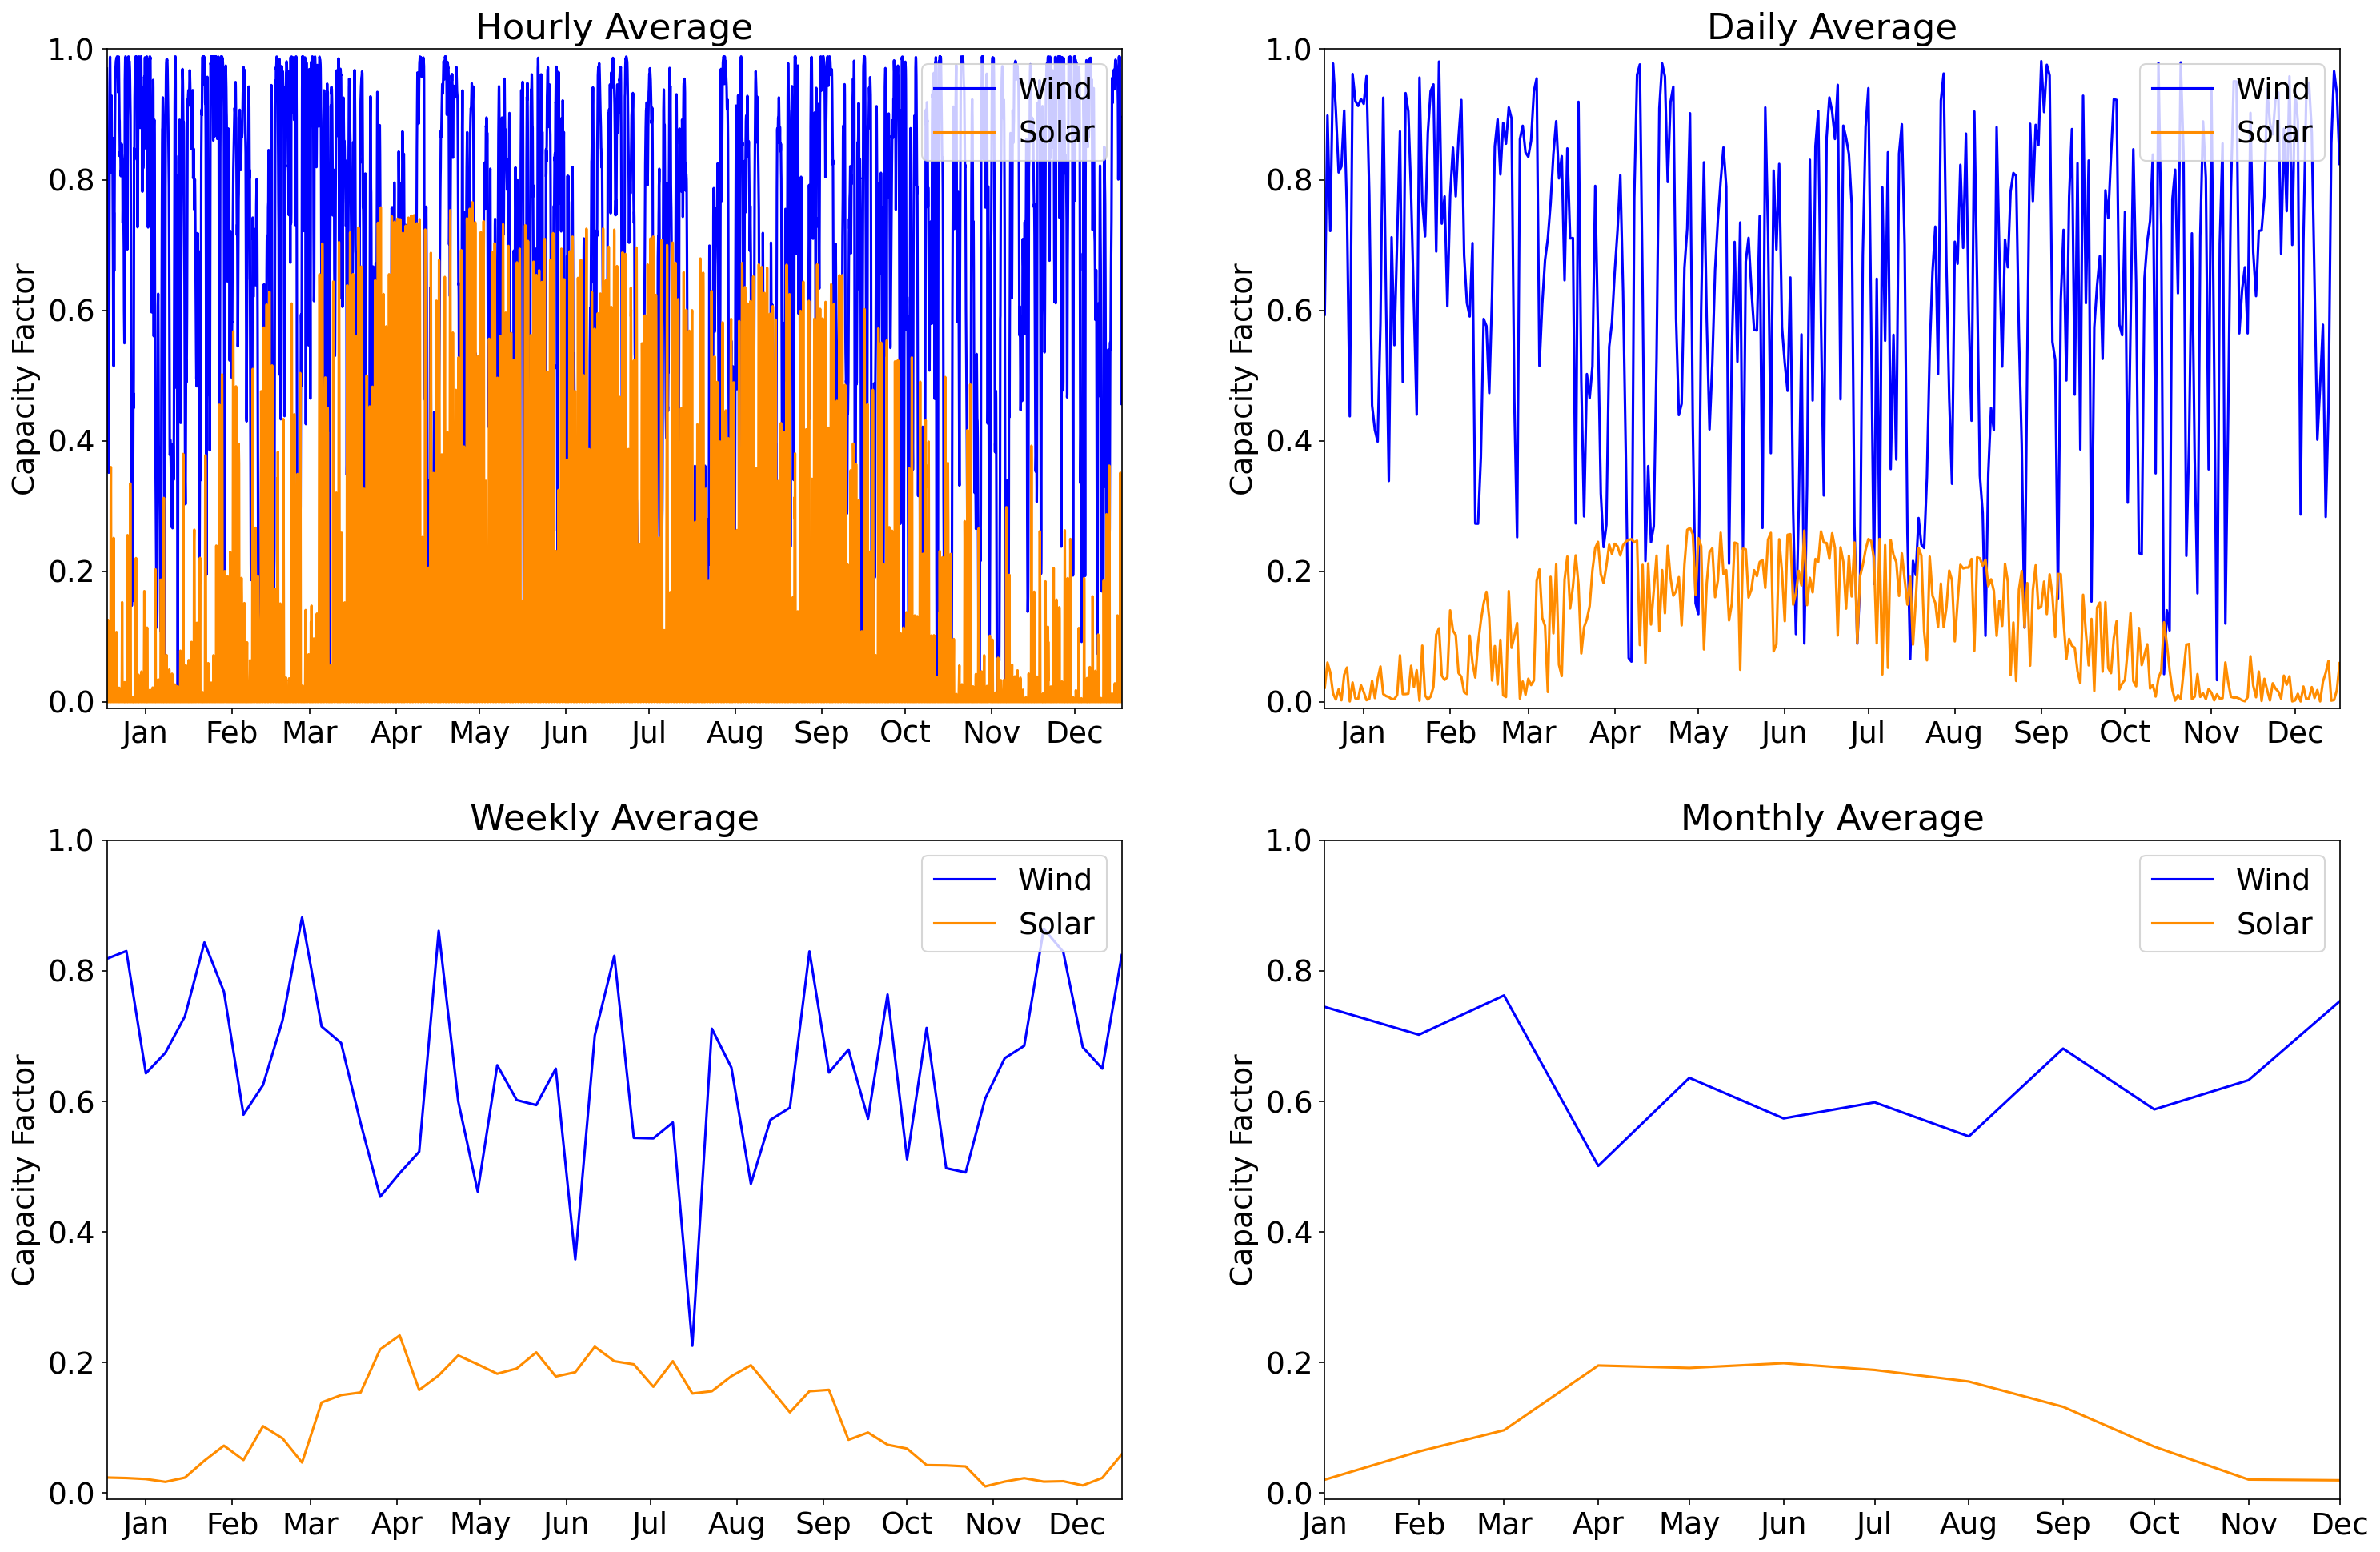

In [4]:
# averaged plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (24,16), dpi = 150)
ax1.plot(cf['Wind'], c = 'blue', label = 'Wind')
ax1.plot(cf['PV'], c = 'darkorange', label = 'Solar')
ax1.set_xticks(['2030-%s-15 00:00'%str(i).rjust(2,'0') for i in range(1,13)])
ax1.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax1.set_xlim('2030-01-01 00:00','2030-12-31 23:00')
ax1.set_ylabel('Capacity Factor')
ax1.set_ylim(-0.01,1)
ax1.set_title('Hourly Average')
ax1.legend(loc = 'upper right')

ax2.plot(cf['Wind'].groupby(pd.Grouper(freq = 'D')).mean(), c = 'blue', label = 'Wind')
ax2.plot(cf['PV'].groupby(pd.Grouper(freq = 'D')).mean(), c = 'darkorange', label = 'Solar')
ax2.set_xticks(['2030-%s-15'%str(i).rjust(2,'0') for i in range(1,13)])
ax2.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax2.set_xlim('2030-01-01','2030-12-31')
ax2.set_ylabel('Capacity Factor')
ax2.set_ylim(-0.01,1)
ax2.set_title('Daily Average')
ax2.legend(loc = 'upper right')

ax3.plot(cf['Wind'].groupby(pd.Grouper(freq = '7D')).mean(), c = 'blue', label = 'Wind')
ax3.plot(cf['PV'].groupby(pd.Grouper(freq = '7D')).mean(), c = 'darkorange', label = 'Solar')
ax3.set_xticks(['2030-%s-15'%str(i).rjust(2,'0') for i in range(1,13)])
ax3.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax3.set_xlim('2030-01-01','2030-12-31')
ax3.set_ylabel('Capacity Factor')
ax3.set_ylim(-0.01,1)
ax3.set_title('Weekly Average')
ax3.legend(loc = 'upper right')

ax4.plot(cf['Wind'].groupby(pd.Grouper(freq = 'MS')).mean(), c = 'blue', label = 'Wind')
ax4.plot(cf['PV'].groupby(pd.Grouper(freq = 'MS')).mean(), c = 'darkorange', label = 'Solar')
ax4.set_xticks(['2030-%s-01'%str(i).rjust(2,'0') for i in range(1,13)])
ax4.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax4.set_xlim('2030-01','2030-12')
ax4.set_ylabel('Capacity Factor')
ax4.set_ylim(-0.01,1)
ax4.set_title('Monthly Average')
ax4.legend(loc = 'upper right')
plt.show()

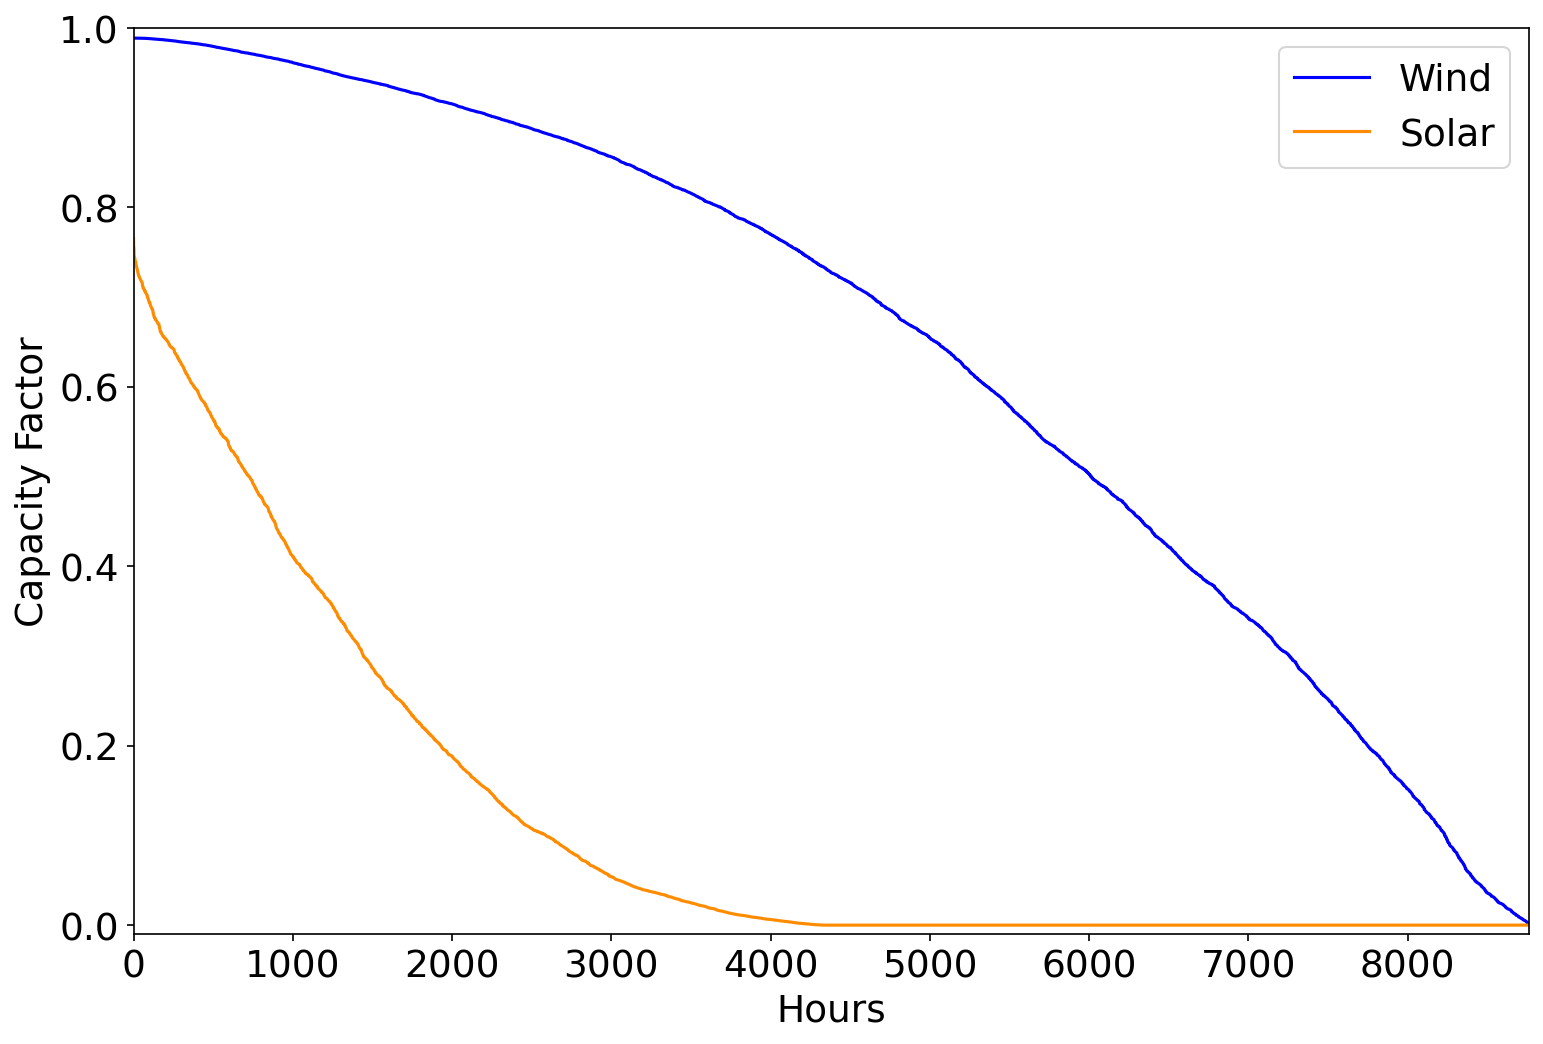

In [5]:
# duration curve
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8), dpi = 150)
ax.plot(range(8760), cf['Wind'].sort_values(ascending = False), c = 'blue', label = 'Wind')
ax.plot(range(8760), cf['PV'].sort_values(ascending = False), c = 'darkorange', label = 'Solar')
ax.set_xlim(0, 8759)
ax.set_ylim(-0.01, 1)
ax.set_xlabel('Hours')
ax.set_ylabel('Capacity Factor')
ax.legend(loc = 'upper right')
plt.show()

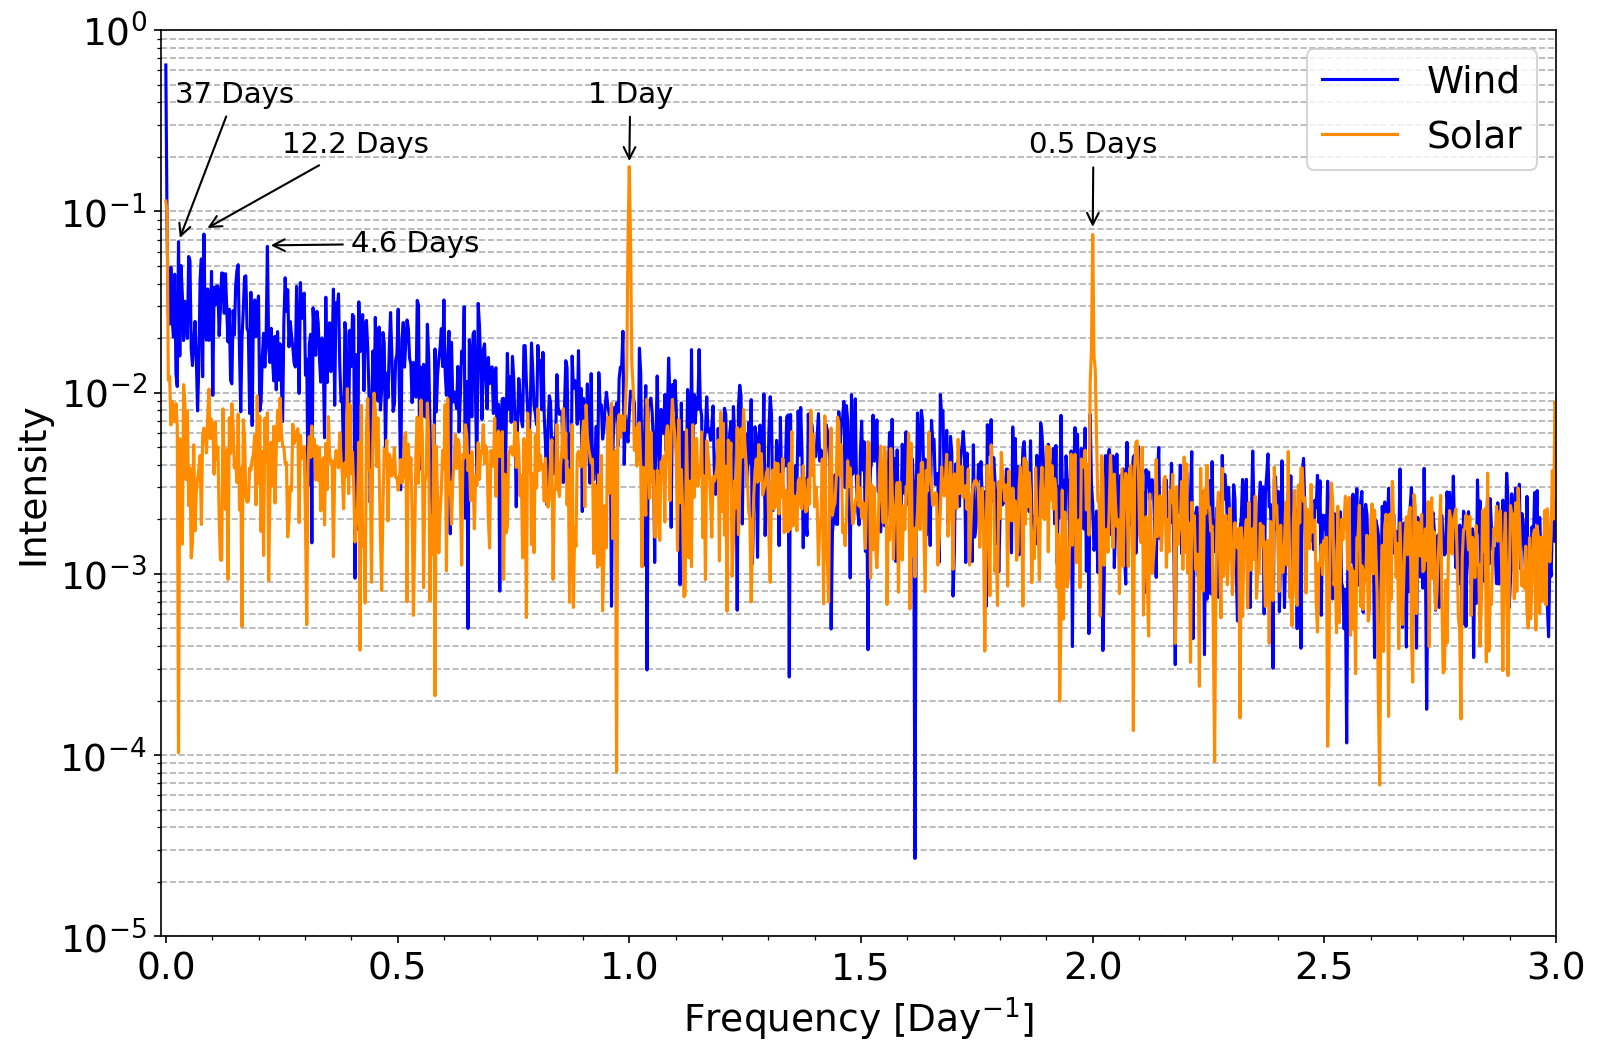

In [6]:
# fourier transform
xwind, temp, ywind = fast_fourier_transform(cf['Wind'],1/3600)
xpv, temp, ypv = fast_fourier_transform(cf['PV'],1/3600)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8), dpi = 150)
ax.plot(xwind*86400, ywind, c = 'blue', label = 'Wind')
ax.plot(xpv*86400, ypv, c = 'darkorange', label = 'Solar')
ax.set_yscale('log')
ax.set_xlim(-1e-2,3)
ax.set_ylim(1e-5,1)
ax.set_xticks(np.arange(0,3,0.1), minor = True)
ax.grid(which = 'both', axis = 'y', linestyle = '--')
ax.set_xlabel(r'Frequency [Day$^{-1}$]')
ax.set_ylabel('Intensity')
ax.legend(loc = 'upper right')
ax.annotate('37 Days', xy = (1/37,0.068), xytext = (0.02,0.4),
             arrowprops = dict(arrowstyle = '->'), fontsize = 14)
ax.annotate('12.2 Days', xy = (1/12.2,0.079), xytext = (0.25,0.21),
             arrowprops = dict(arrowstyle = '->'), fontsize = 14)
ax.annotate('4.6 Days', xy = (1/4.6,0.065), xytext = (0.4,0.06),
             arrowprops = dict(arrowstyle = '->'), fontsize = 14)
ax.annotate('1 Day', xy = (1,0.18), xytext = (0.91,0.4),
             arrowprops = dict(arrowstyle = '->'), fontsize = 14)
ax.annotate('0.5 Days', xy = (2,0.078), xytext = (1.863,0.21),
             arrowprops = dict(arrowstyle = '->'), fontsize = 14)
plt.show()

In [7]:
country = ['DK','DE','NO','NL','GB']
binary_list = []
for i in range(2**len(country)):
    binary_list.append(f'{{:0{len(country)}b}}'.format(i)) # binary switch for countries

# read all saved network files
locvar = locals()
for year in [2030,2040,2050]:
    for fuel in ['H2','NH3']:
        for binary in binary_list:
            locvar['network_%d_%s_%s'%(year,fuel,binary)] = pypsa.Network('results/%d_%s_%s.nc'%(year,fuel,binary))

INFO:pypsa.io:Imported network 2030_H2_00000.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2030_H2_00001.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2030_H2_00010.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2030_H2_00011.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2030_H2_00100.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2030_H2_00101.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2030_H2_00110.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2030_H2_00111.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2030_H2_01000.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2030_H2_01001.nc has buses, generators, links, loads, storage_units
INFO:pypsa

INFO:pypsa.io:Imported network 2040_H2_10011.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2040_H2_10100.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2040_H2_10101.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2040_H2_10110.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2040_H2_10111.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2040_H2_11000.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2040_H2_11001.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2040_H2_11010.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2040_H2_11011.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2040_H2_11100.nc has buses, generators, links, loads, storage_units
INFO:pypsa

INFO:pypsa.io:Imported network 2050_NH3_00110.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2050_NH3_00111.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2050_NH3_01000.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2050_NH3_01001.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2050_NH3_01010.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2050_NH3_01011.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2050_NH3_01100.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2050_NH3_01101.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2050_NH3_01110.nc has buses, generators, links, loads, storage_units
INFO:pypsa.io:Imported network 2050_NH3_01111.nc has buses, generators, links, loads, storage_units


In [8]:
# all levelized fuel costs
lfc = [] # €/MWh
for year in [2030,2040,2050]:
    for fuel in ['H2','NH3']:
        for binary in binary_list:
            # tiny standard deviation, no difference than weighted average
            lfc.append(locvar['network_%d_%s_%s'%(year,fuel,binary)].buses_t.marginal_price[fuel].mean())

In [9]:
# bar chart preparation
barcolors = ['black']
combination = ['Isolated'] # ticks
for binary in binary_list:
    if binary == '00000':
        continue
    for i,j in zip(binary,country):
        if int(i):
            try:
                combination[binary_list.index(binary)] += '+'+j
            except IndexError:
                combination.append(j)
    if len(combination[-1]) == 2:
        barcolors.append('red')
    elif len(combination[-1]) == 5:
        barcolors.append('gold')
    elif len(combination[-1]) == 8:
        barcolors.append('limegreen')
    elif len(combination[-1]) == 11:
        barcolors.append('dodgerblue')
    elif len(combination[-1]) == 14:
        barcolors.append('darkviolet')

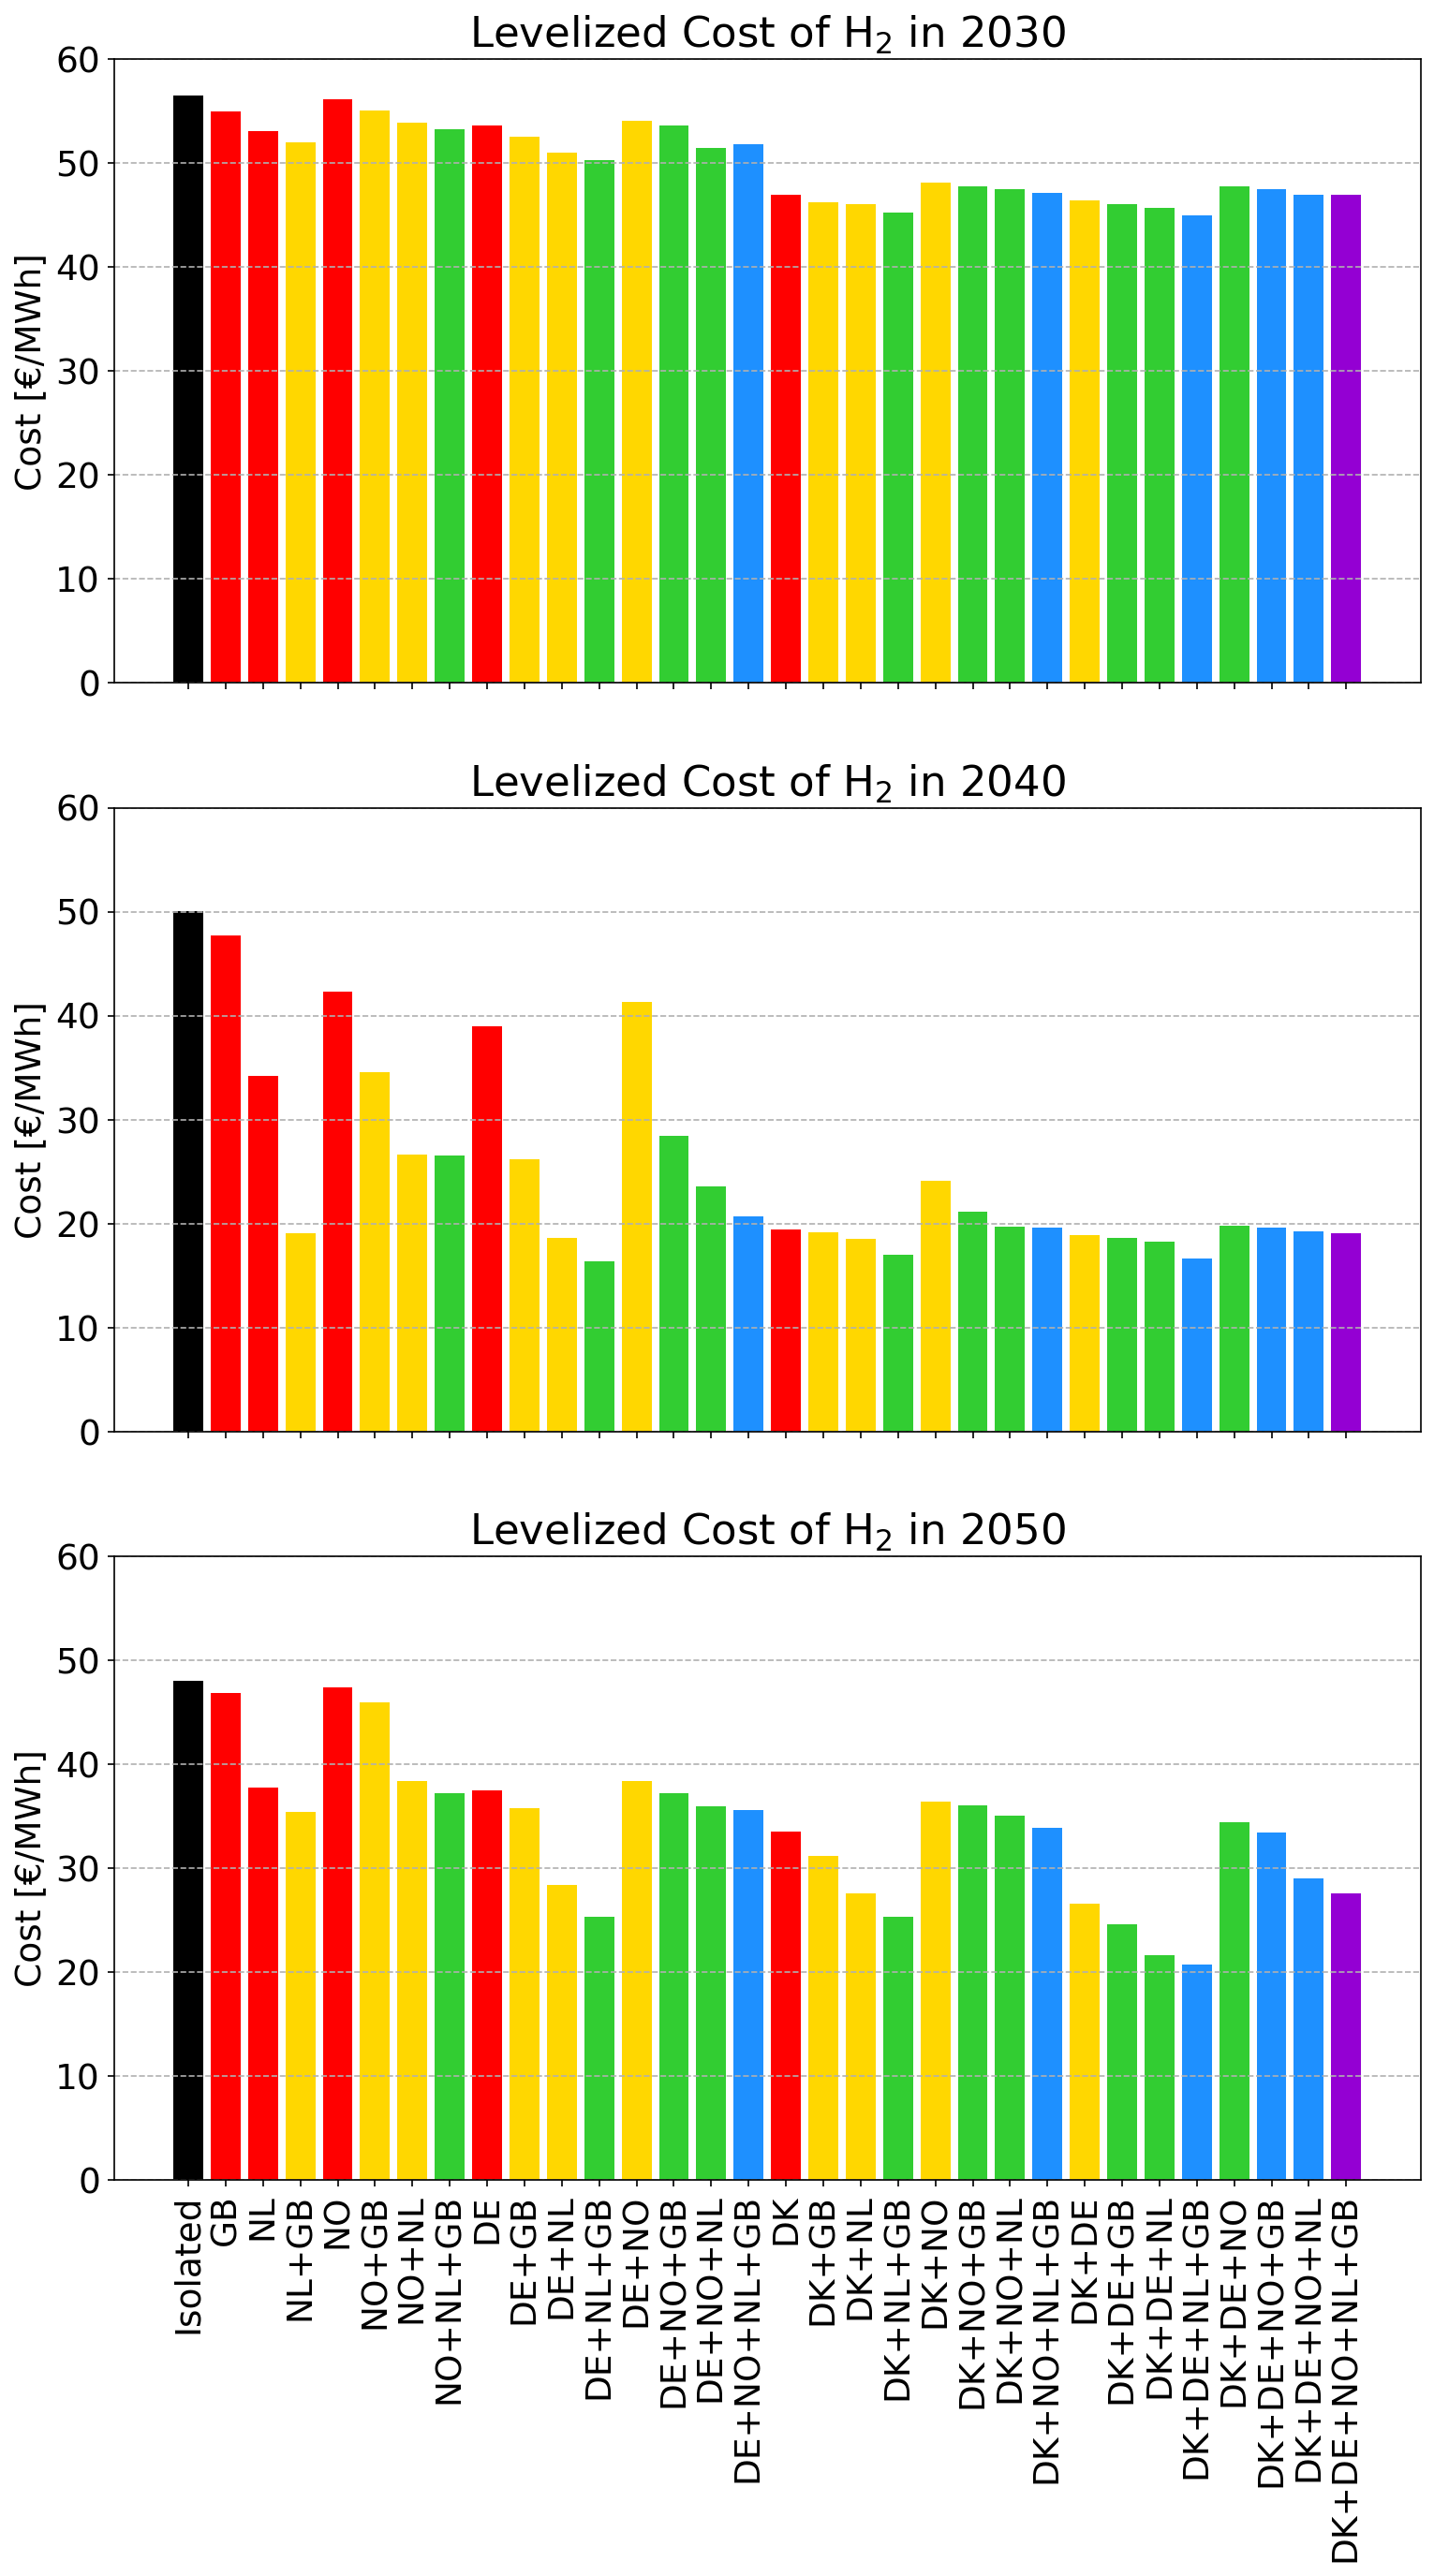

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, sharex = True, figsize = (12,20), dpi = 150)
ax1.bar(combination, lfc[0:32], color = barcolors)
ax1.set_ylim(0,60)
ax1.set_yticks(np.arange(0,61,10))
ax1.grid(axis = 'y', linestyle = '--')
ax1.set_title(r'Levelized Cost of H$_2$ in 2030')
ax1.set_ylabel('Cost [€/MWh]')

ax2.bar(combination, lfc[64:96], color = barcolors)
ax2.set_ylim(0,60)
ax2.set_yticks(np.arange(0,61,10))
ax2.grid(axis = 'y', linestyle = '--')
ax2.set_title(r'Levelized Cost of H$_2$ in 2040')
ax2.set_ylabel('Cost [€/MWh]')

ax3.bar(combination, lfc[128:160], color = barcolors)
ax3.set_ylim(0,60)
ax3.set_yticks(np.arange(0,61,10))
ax3.grid(axis = 'y', linestyle = '--')
ax3.set_title(r'Levelized Cost of H$_2$ in 2050')
ax3.set_ylabel('Cost [€/MWh]')
ax3.tick_params(axis = 'x', rotation = 90)
plt.show()

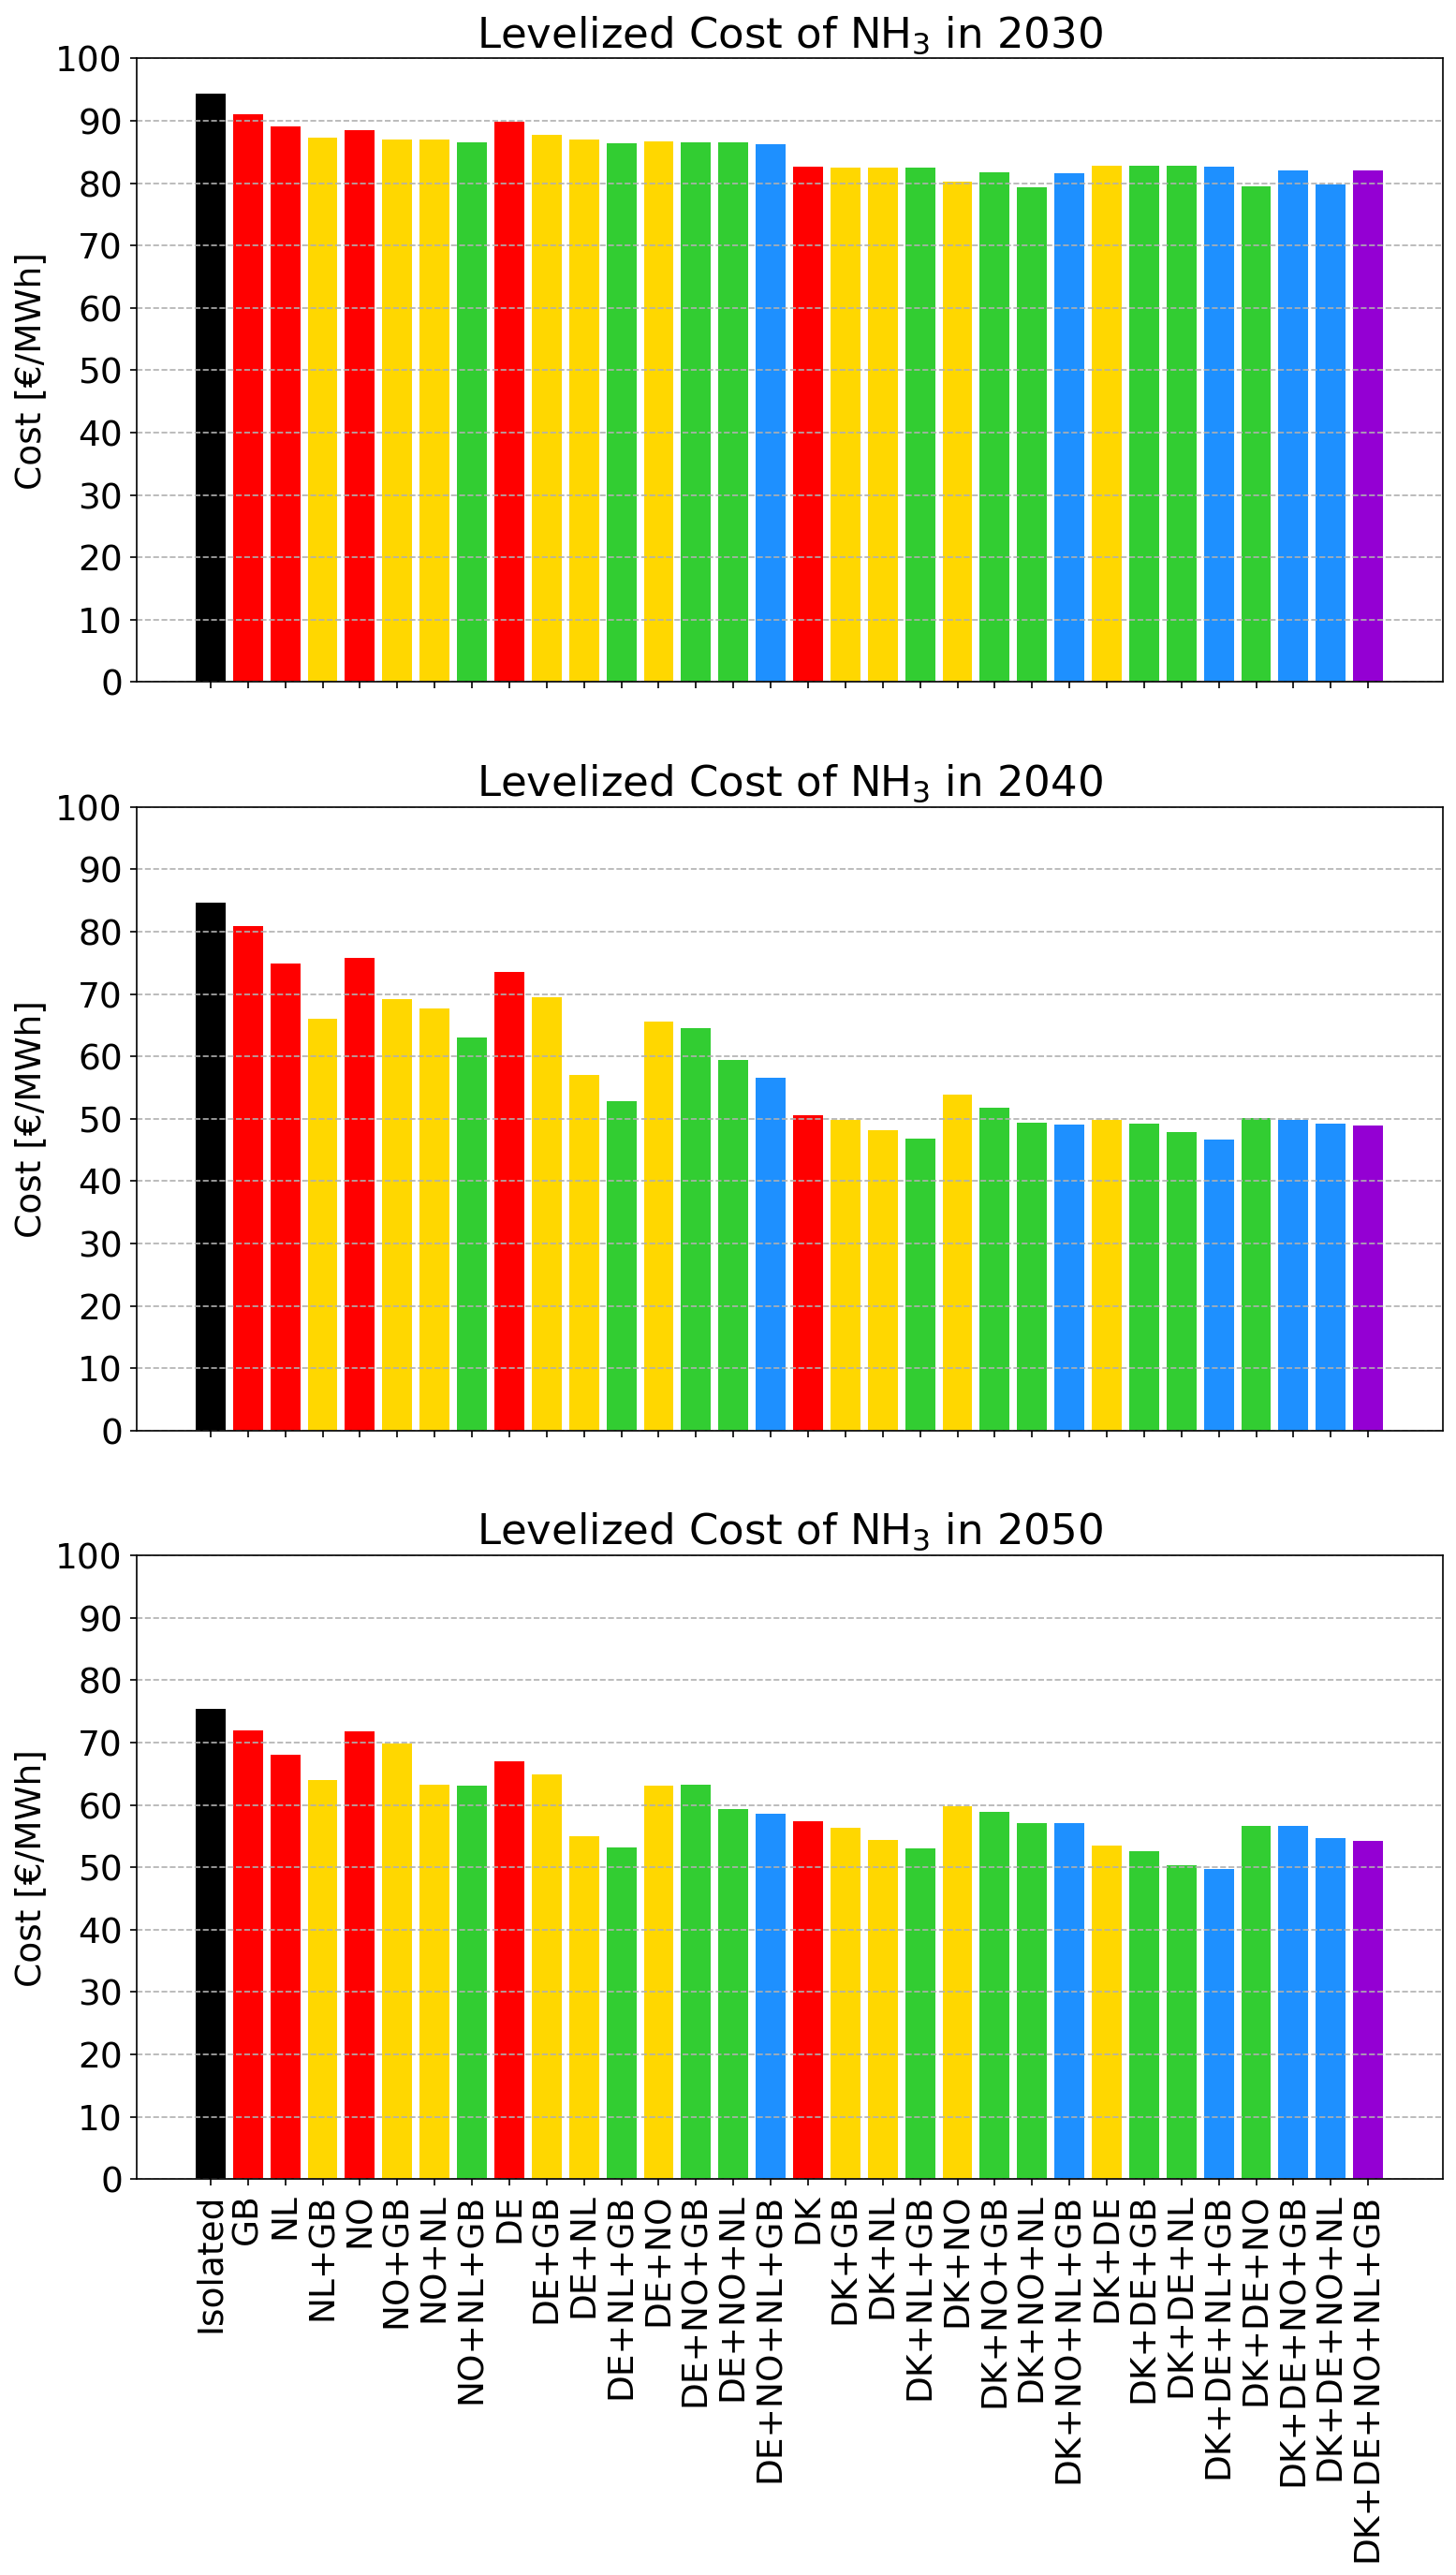

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, sharex = True, figsize = (12,20), dpi = 150)
ax1.bar(combination, lfc[32:64], color = barcolors)
ax1.set_ylim(0,100)
ax1.set_yticks(np.arange(0,101,10))
ax1.grid(axis = 'y', linestyle = '--')
ax1.set_title(r'Levelized Cost of NH$_3$ in 2030')
ax1.set_ylabel('Cost [€/MWh]')

ax2.bar(combination, lfc[96:128], color = barcolors)
ax2.set_ylim(0,100)
ax2.set_yticks(np.arange(0,101,10))
ax2.grid(axis = 'y', linestyle = '--')
ax2.set_title(r'Levelized Cost of NH$_3$ in 2040')
ax2.set_ylabel('Cost [€/MWh]')

ax3.bar(combination, lfc[160:192], color = barcolors)
ax3.set_ylim(0,100)
ax3.set_yticks(np.arange(0,101,10))
ax3.grid(axis = 'y', linestyle = '--')
ax3.set_title(r'Levelized Cost of NH$_3$ in 2050')
ax3.set_ylabel('Cost [€/MWh]')
ax3.tick_params(axis = 'x', rotation = 90)
plt.show()

In [12]:
# objective funtion, total cost
obj = [] # B€
for year in [2030,2040,2050]:
    for fuel in ['H2','NH3']:
        for binary in binary_list:
            obj.append(locvar['network_%d_%s_%s'%(year,fuel,binary)].objective/1e9)

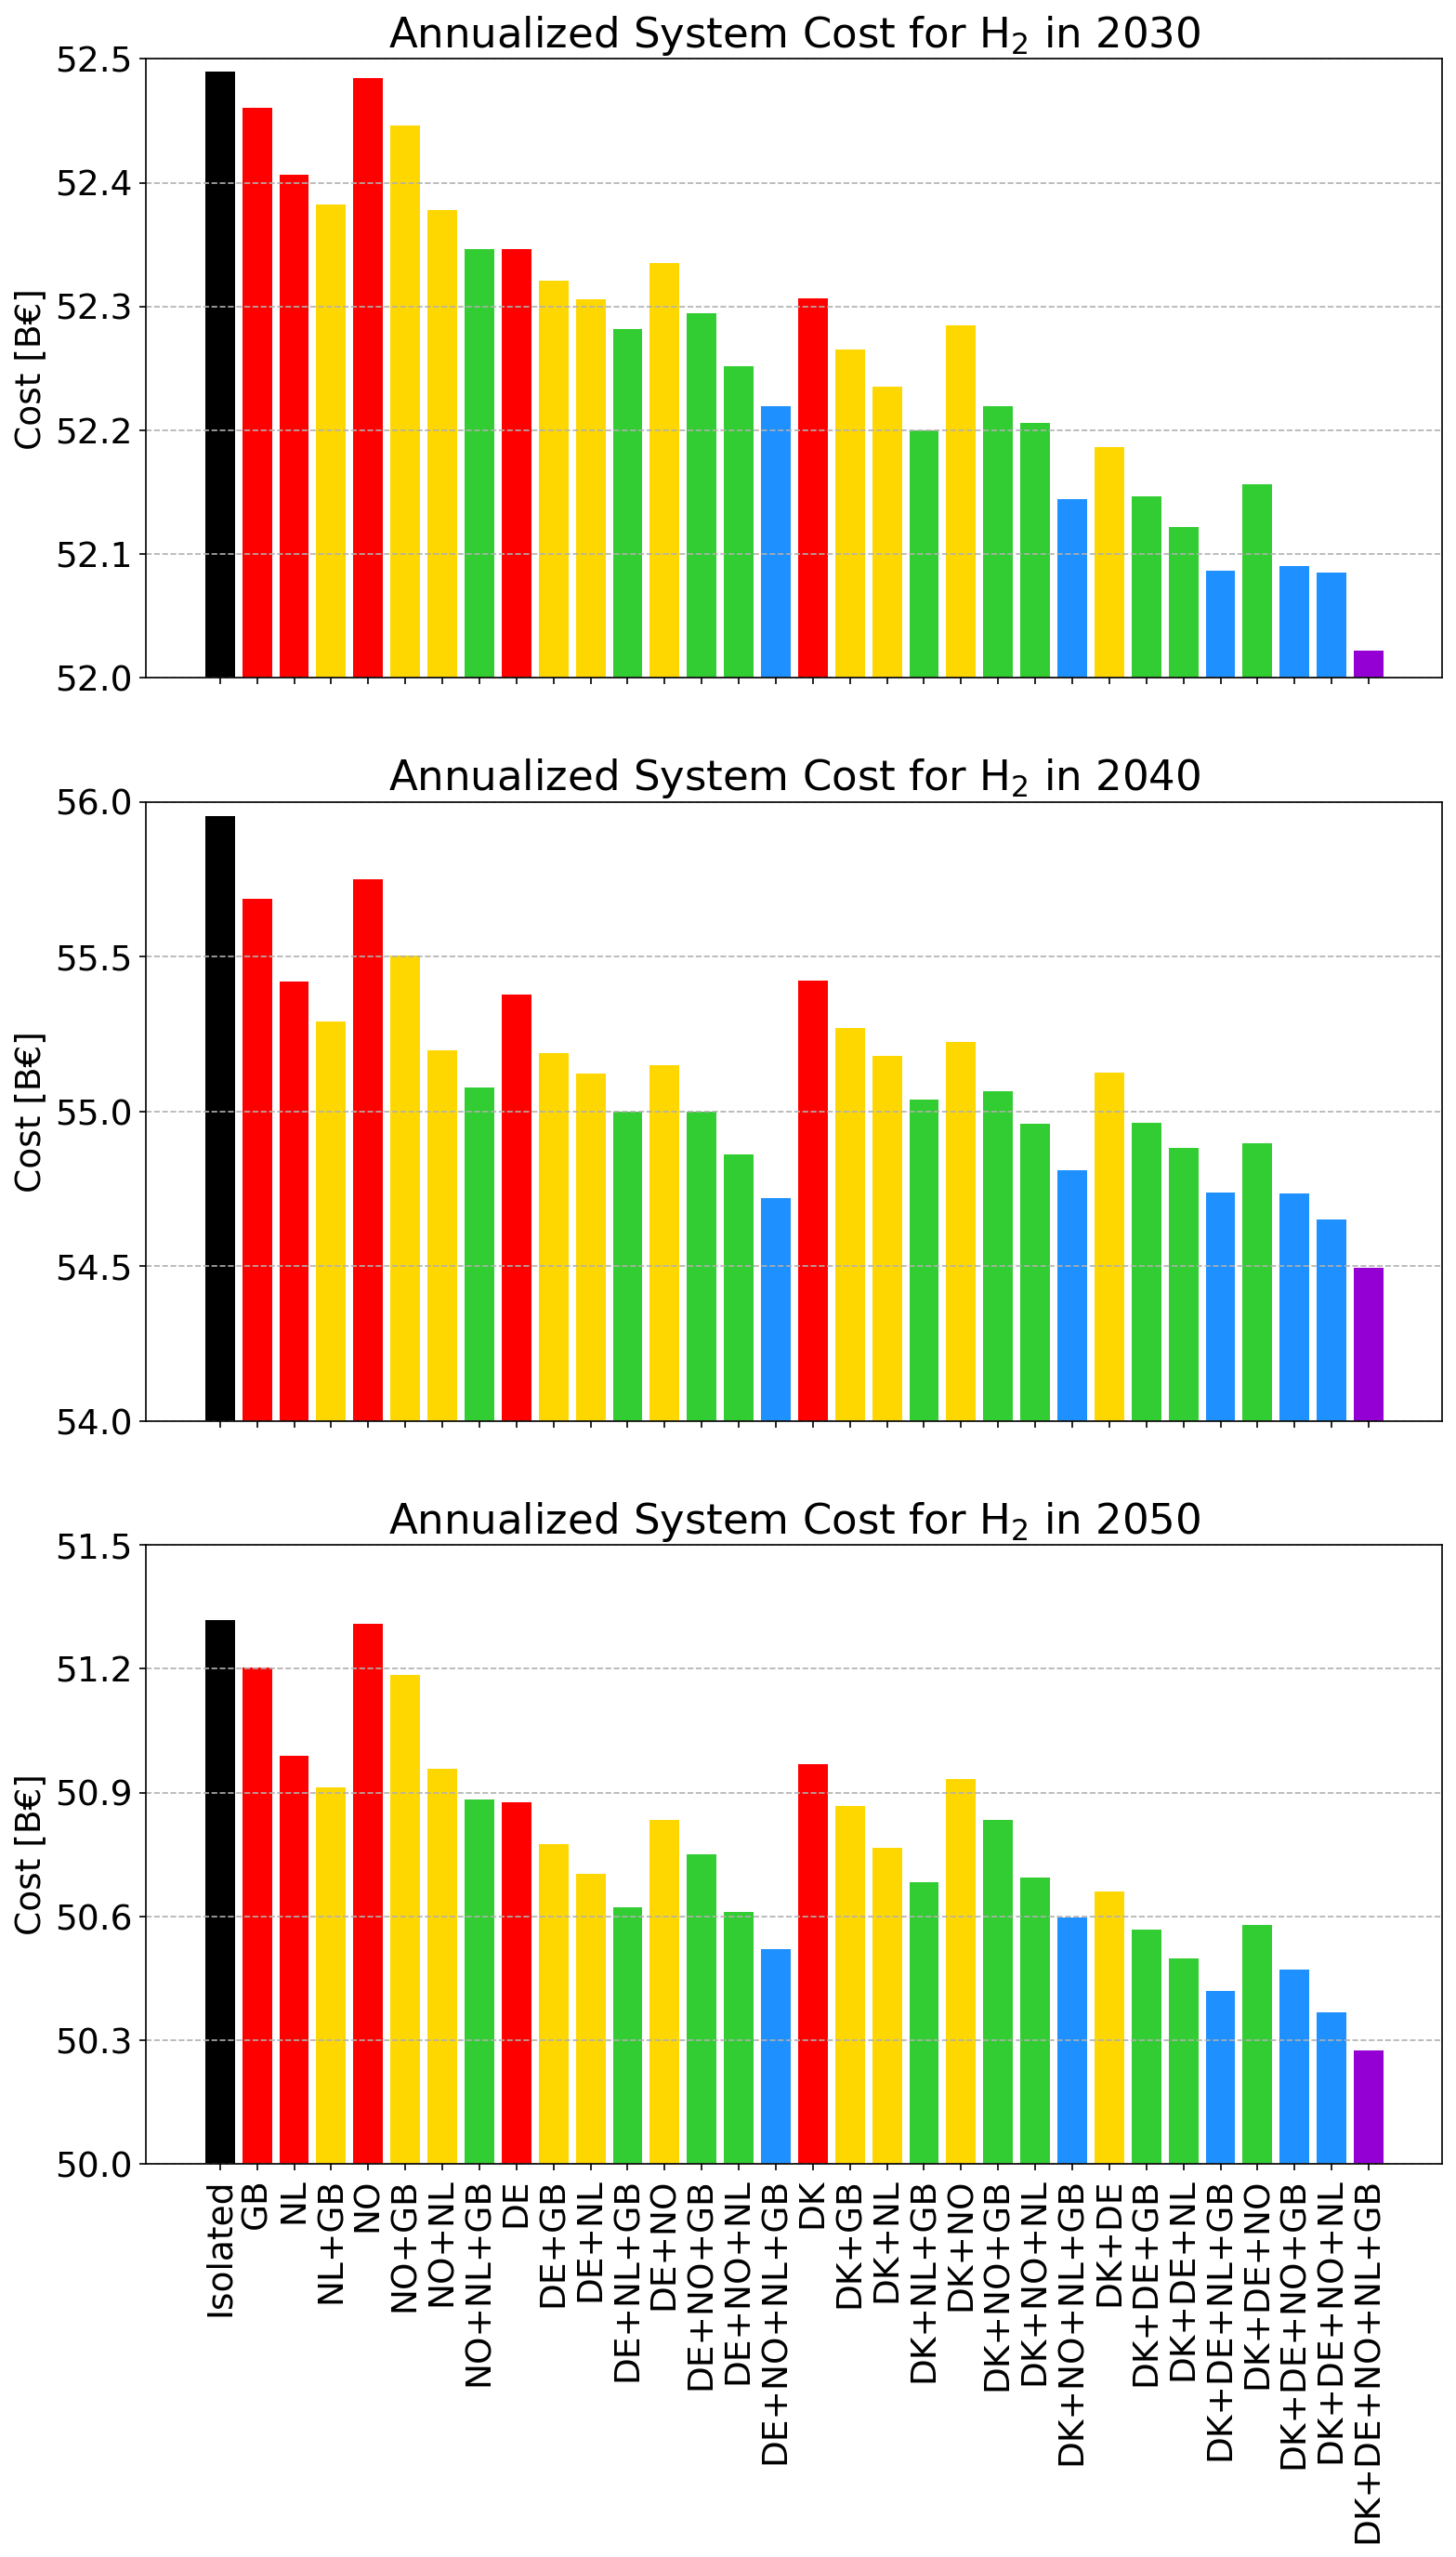

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, sharex = True, figsize = (12,20), dpi = 150)
ax1.bar(combination, obj[0:32], color = barcolors)
ax1.set_ylim(52,52.5)
ax1.set_yticks(np.arange(52,52.51,0.1))
ax1.grid(axis = 'y', linestyle = '--')
ax1.set_title(r'Annualized System Cost for H$_2$ in 2030')
ax1.set_ylabel('Cost [B€]')

ax2.bar(combination, obj[64:96], color = barcolors)
ax2.set_ylim(54,56)
ax2.set_yticks(np.arange(54,56.01,0.5))
ax2.grid(axis = 'y', linestyle = '--')
ax2.set_title(r'Annualized System Cost for H$_2$ in 2040')
ax2.set_ylabel('Cost [B€]')

ax3.bar(combination, obj[128:160], color = barcolors)
ax3.set_ylim(50,51.5)
ax3.set_yticks(np.arange(50,51.51,0.3))
ax3.grid(axis = 'y', linestyle = '--')
ax3.set_title(r'Annualized System Cost for H$_2$ in 2050')
ax3.set_ylabel('Cost [B€]')
ax3.tick_params(axis = 'x', rotation = 90)
plt.show()

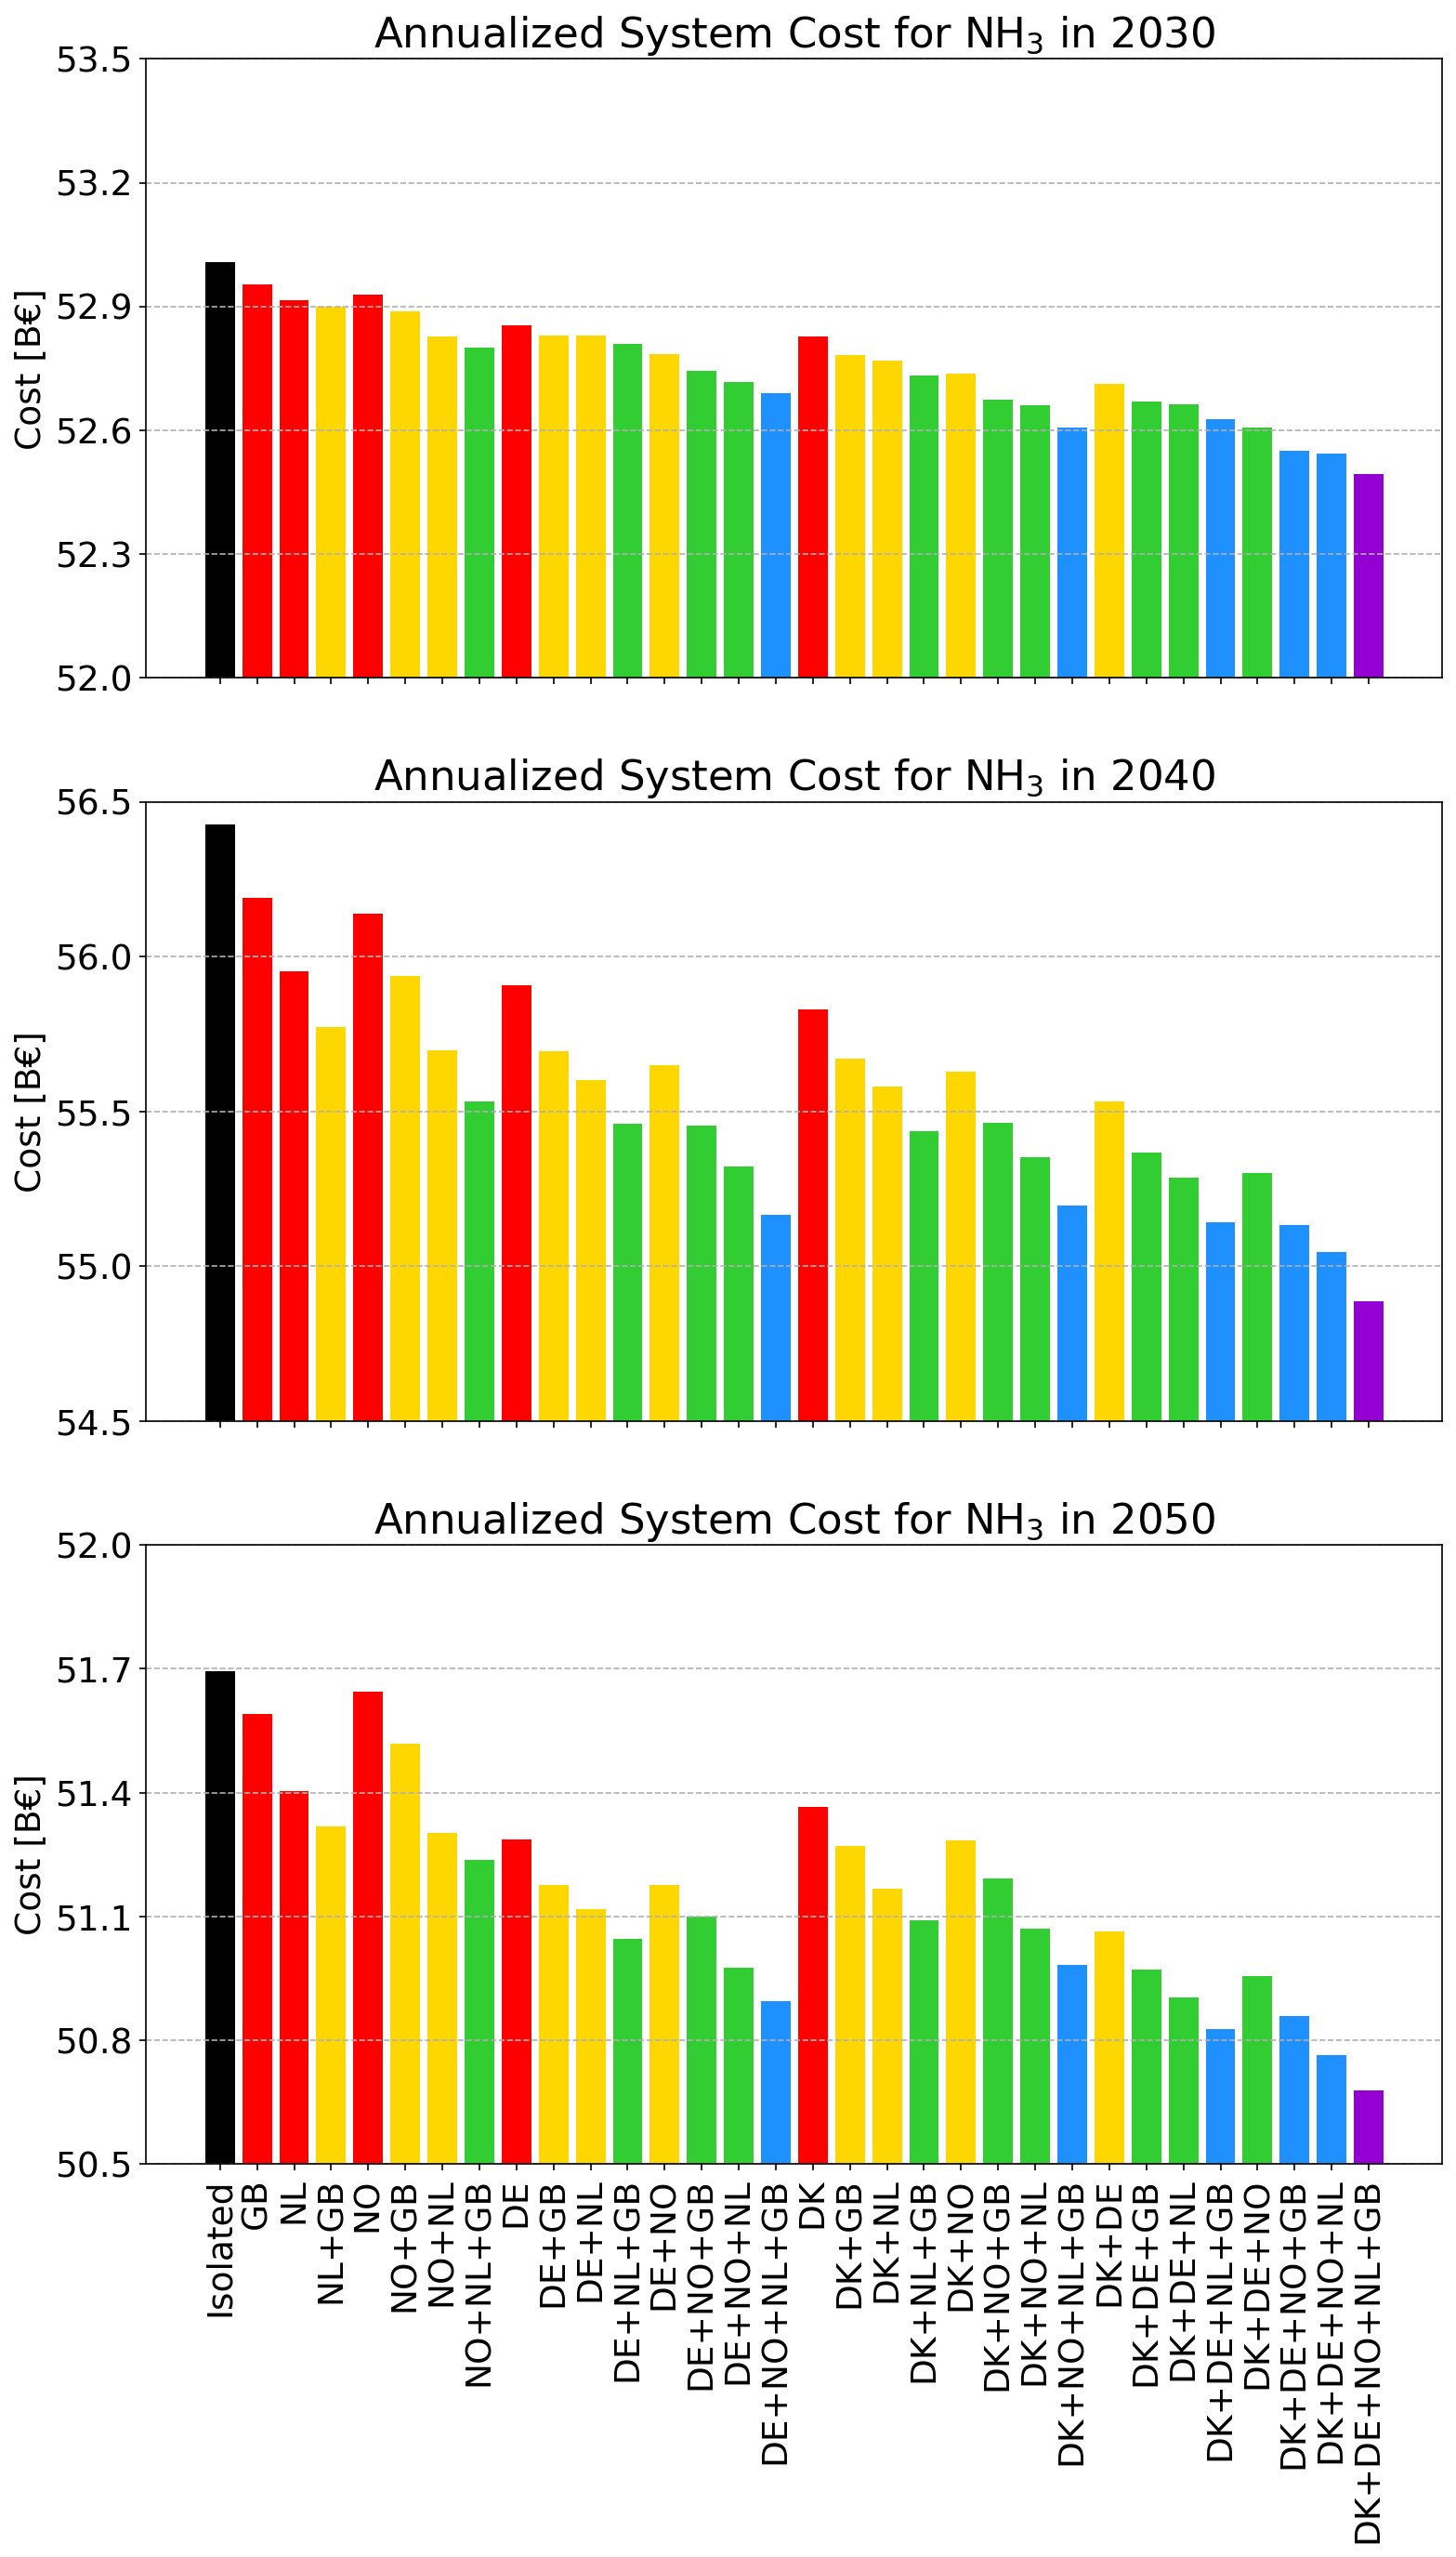

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, sharex = True, figsize = (12,20), dpi = 150)
ax1.bar(combination, obj[32:64], color = barcolors)
ax1.set_ylim(52,53.5)
ax1.set_yticks(np.arange(52,53.51,0.3))
ax1.grid(axis = 'y', linestyle = '--')
ax1.set_title(r'Annualized System Cost for NH$_3$ in 2030')
ax1.set_ylabel('Cost [B€]')

ax2.bar(combination, obj[96:128], color = barcolors)
ax2.set_ylim(54.5,56.5)
ax2.set_yticks(np.arange(54.5,56.51,0.5))
ax2.grid(axis = 'y', linestyle = '--')
ax2.set_title(r'Annualized System Cost for NH$_3$ in 2040')
ax2.set_ylabel('Cost [B€]')

ax3.bar(combination, obj[160:192], color = barcolors)
ax3.set_ylim(50.5,52)
ax3.set_yticks(np.arange(50.5,52.01,0.3))
ax3.grid(axis = 'y', linestyle = '--')
ax3.set_title(r'Annualized System Cost for NH$_3$ in 2050')
ax3.set_ylabel('Cost [B€]')
ax3.tick_params(axis = 'x', rotation = 90)
plt.show()

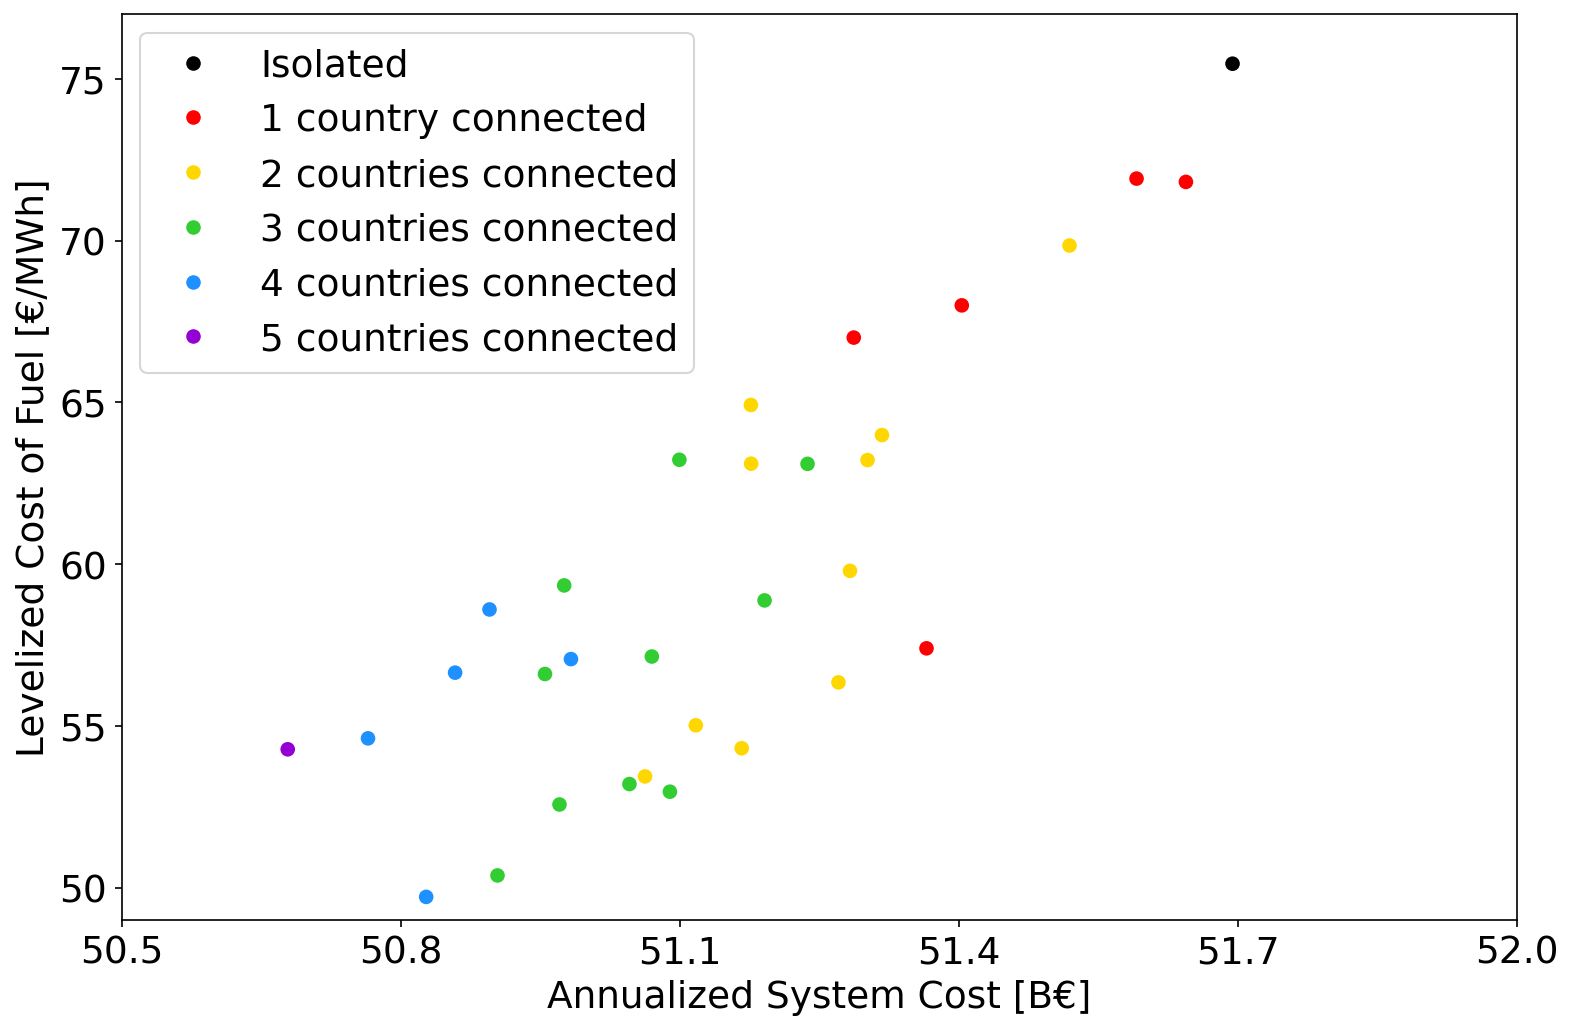

In [15]:
# sample: NH3, 2050
legend_elements = [
    Line2D([0], [0], marker = 'o', color = 'w', label = 'Isolated',
           markerfacecolor = 'black', markersize = 8),
    Line2D([0], [0], marker = 'o', color = 'w', label = '1 country connected',
           markerfacecolor = 'red', markersize = 8),
    Line2D([0], [0], marker = 'o', color = 'w', label = '2 countries connected',
           markerfacecolor = 'gold', markersize = 8),
    Line2D([0], [0], marker = 'o', color = 'w', label = '3 countries connected',
           markerfacecolor = 'limegreen', markersize = 8),
    Line2D([0], [0], marker = 'o', color = 'w', label = '4 countries connected',
           markerfacecolor = 'dodgerblue', markersize = 8),
    Line2D([0], [0], marker = 'o', color = 'w', label = '5 countries connected',
           markerfacecolor = 'darkviolet', markersize = 8)
]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8), dpi = 150)
ax.scatter(obj[160:192], lfc[160:192], color = barcolors)
ax.set_xlim(50.5,52)
ax.set_xticks(np.arange(50.5,52.01,0.3))
ax.set_ylim(49,77)
ax.set_xlabel('Annualized System Cost [B€]')
ax.set_ylabel('Levelized Cost of Fuel [€/MWh]')
ax.legend(handles = legend_elements, loc = 'upper left')
plt.show()

In [16]:
def get_bar_capacities(binary):
    index = ['Offshore Wind','Battery','Fuel Plant']
    for i,j in zip(binary,country):
        if int(i): index.append(j+' Link')
    capacities = pd.DataFrame(
        columns = [f'{year}_{fuel}' for year in [2030,2040,2050] for fuel in ['H2','NH3']], index = index
    )
    for year in [2030,2040,2050]:
        for fuel in ['H2','NH3']:
            capacities.loc[:,f'{year}_{fuel}'] = np.concatenate(
                (locvar['network_%d_%s_%s'%(year,fuel,binary)].generators.p_nom_opt.filter(regex = r'Wind|Solar'),
                 locvar['network_%d_%s_%s'%(year,fuel,binary)].storage_units.p_nom_opt.filter(regex = r'Battery'),
                 locvar['network_%d_%s_%s'%(year,fuel,binary)].links.p_nom_opt.filter(regex = r'Plant| and '))
            )
    return capacities

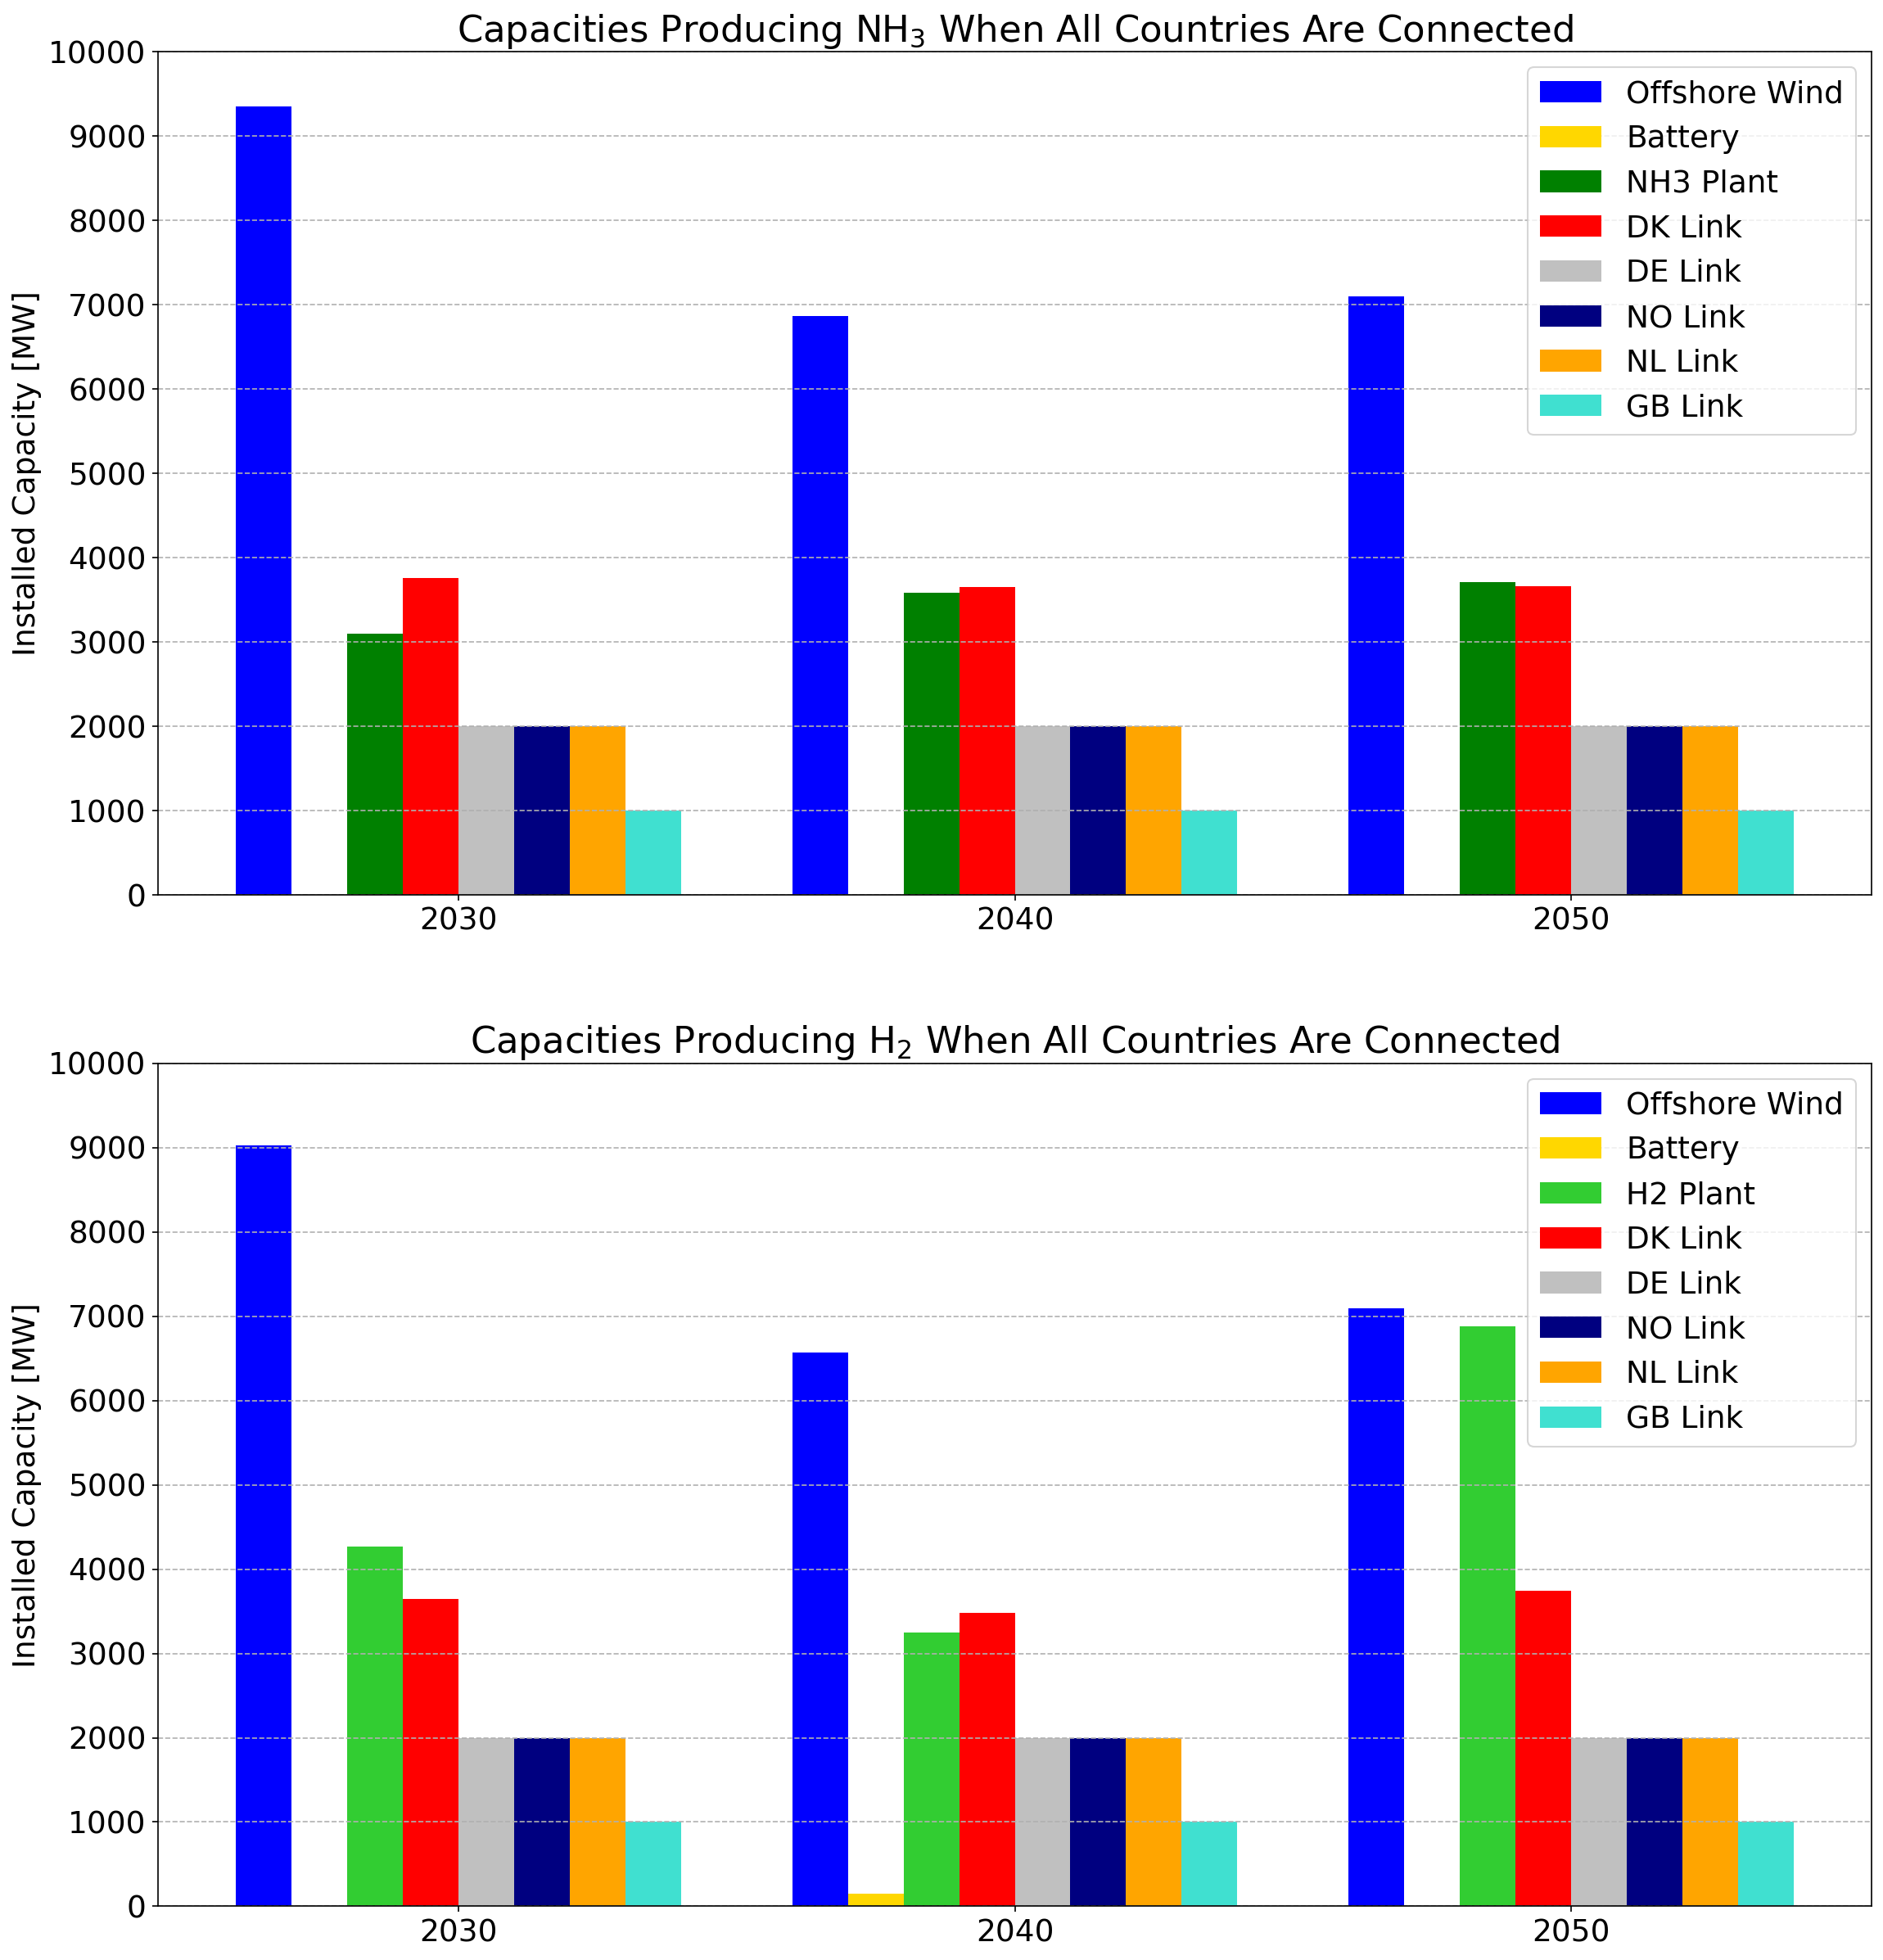

In [17]:
capacities = get_bar_capacities('11111') # all countries connected
colors = ['blue','gold','green','red','silver','navy','orange','turquoise']

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (18,20), dpi = 150)
x = np.arange(3)
width = 0.1
for i,j in zip(np.arange(len(capacities.index)),capacities.index):
    ax1.bar(x+width*i, capacities.loc[j].filter(regex = r'NH3'), width, color = colors[i],
            label = j if j != 'Fuel Plant' else 'NH3 Plant')
    ax2.bar(x+width*i, capacities.loc[j].filter(regex = r'H2'), width, 
            color = colors[i] if j != 'Fuel Plant' else 'limegreen',
            label = j if j != 'Fuel Plant' else 'H2 Plant')
ax1.set_ylim(0,10000)
ax2.set_ylim(0,10000)
ax1.grid(axis = 'y', linestyle = '--')
ax2.grid(axis = 'y', linestyle = '--')
ax1.set_title(r'Capacities Producing NH$_3$ When All Countries Are Connected')
ax2.set_title(r'Capacities Producing H$_2$ When All Countries Are Connected')
ax1.set_ylabel('Installed Capacity [MW]')
ax2.set_ylabel('Installed Capacity [MW]')
ax1.set_xticks(x+width*3.5)
ax2.set_xticks(x+width*3.5)
ax1.set_xticklabels([2030,2040,2050])
ax2.set_xticklabels([2030,2040,2050])
ax1.set_yticks(np.arange(0,10001,1000))
ax2.set_yticks(np.arange(0,10001,1000))
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
plt.show()

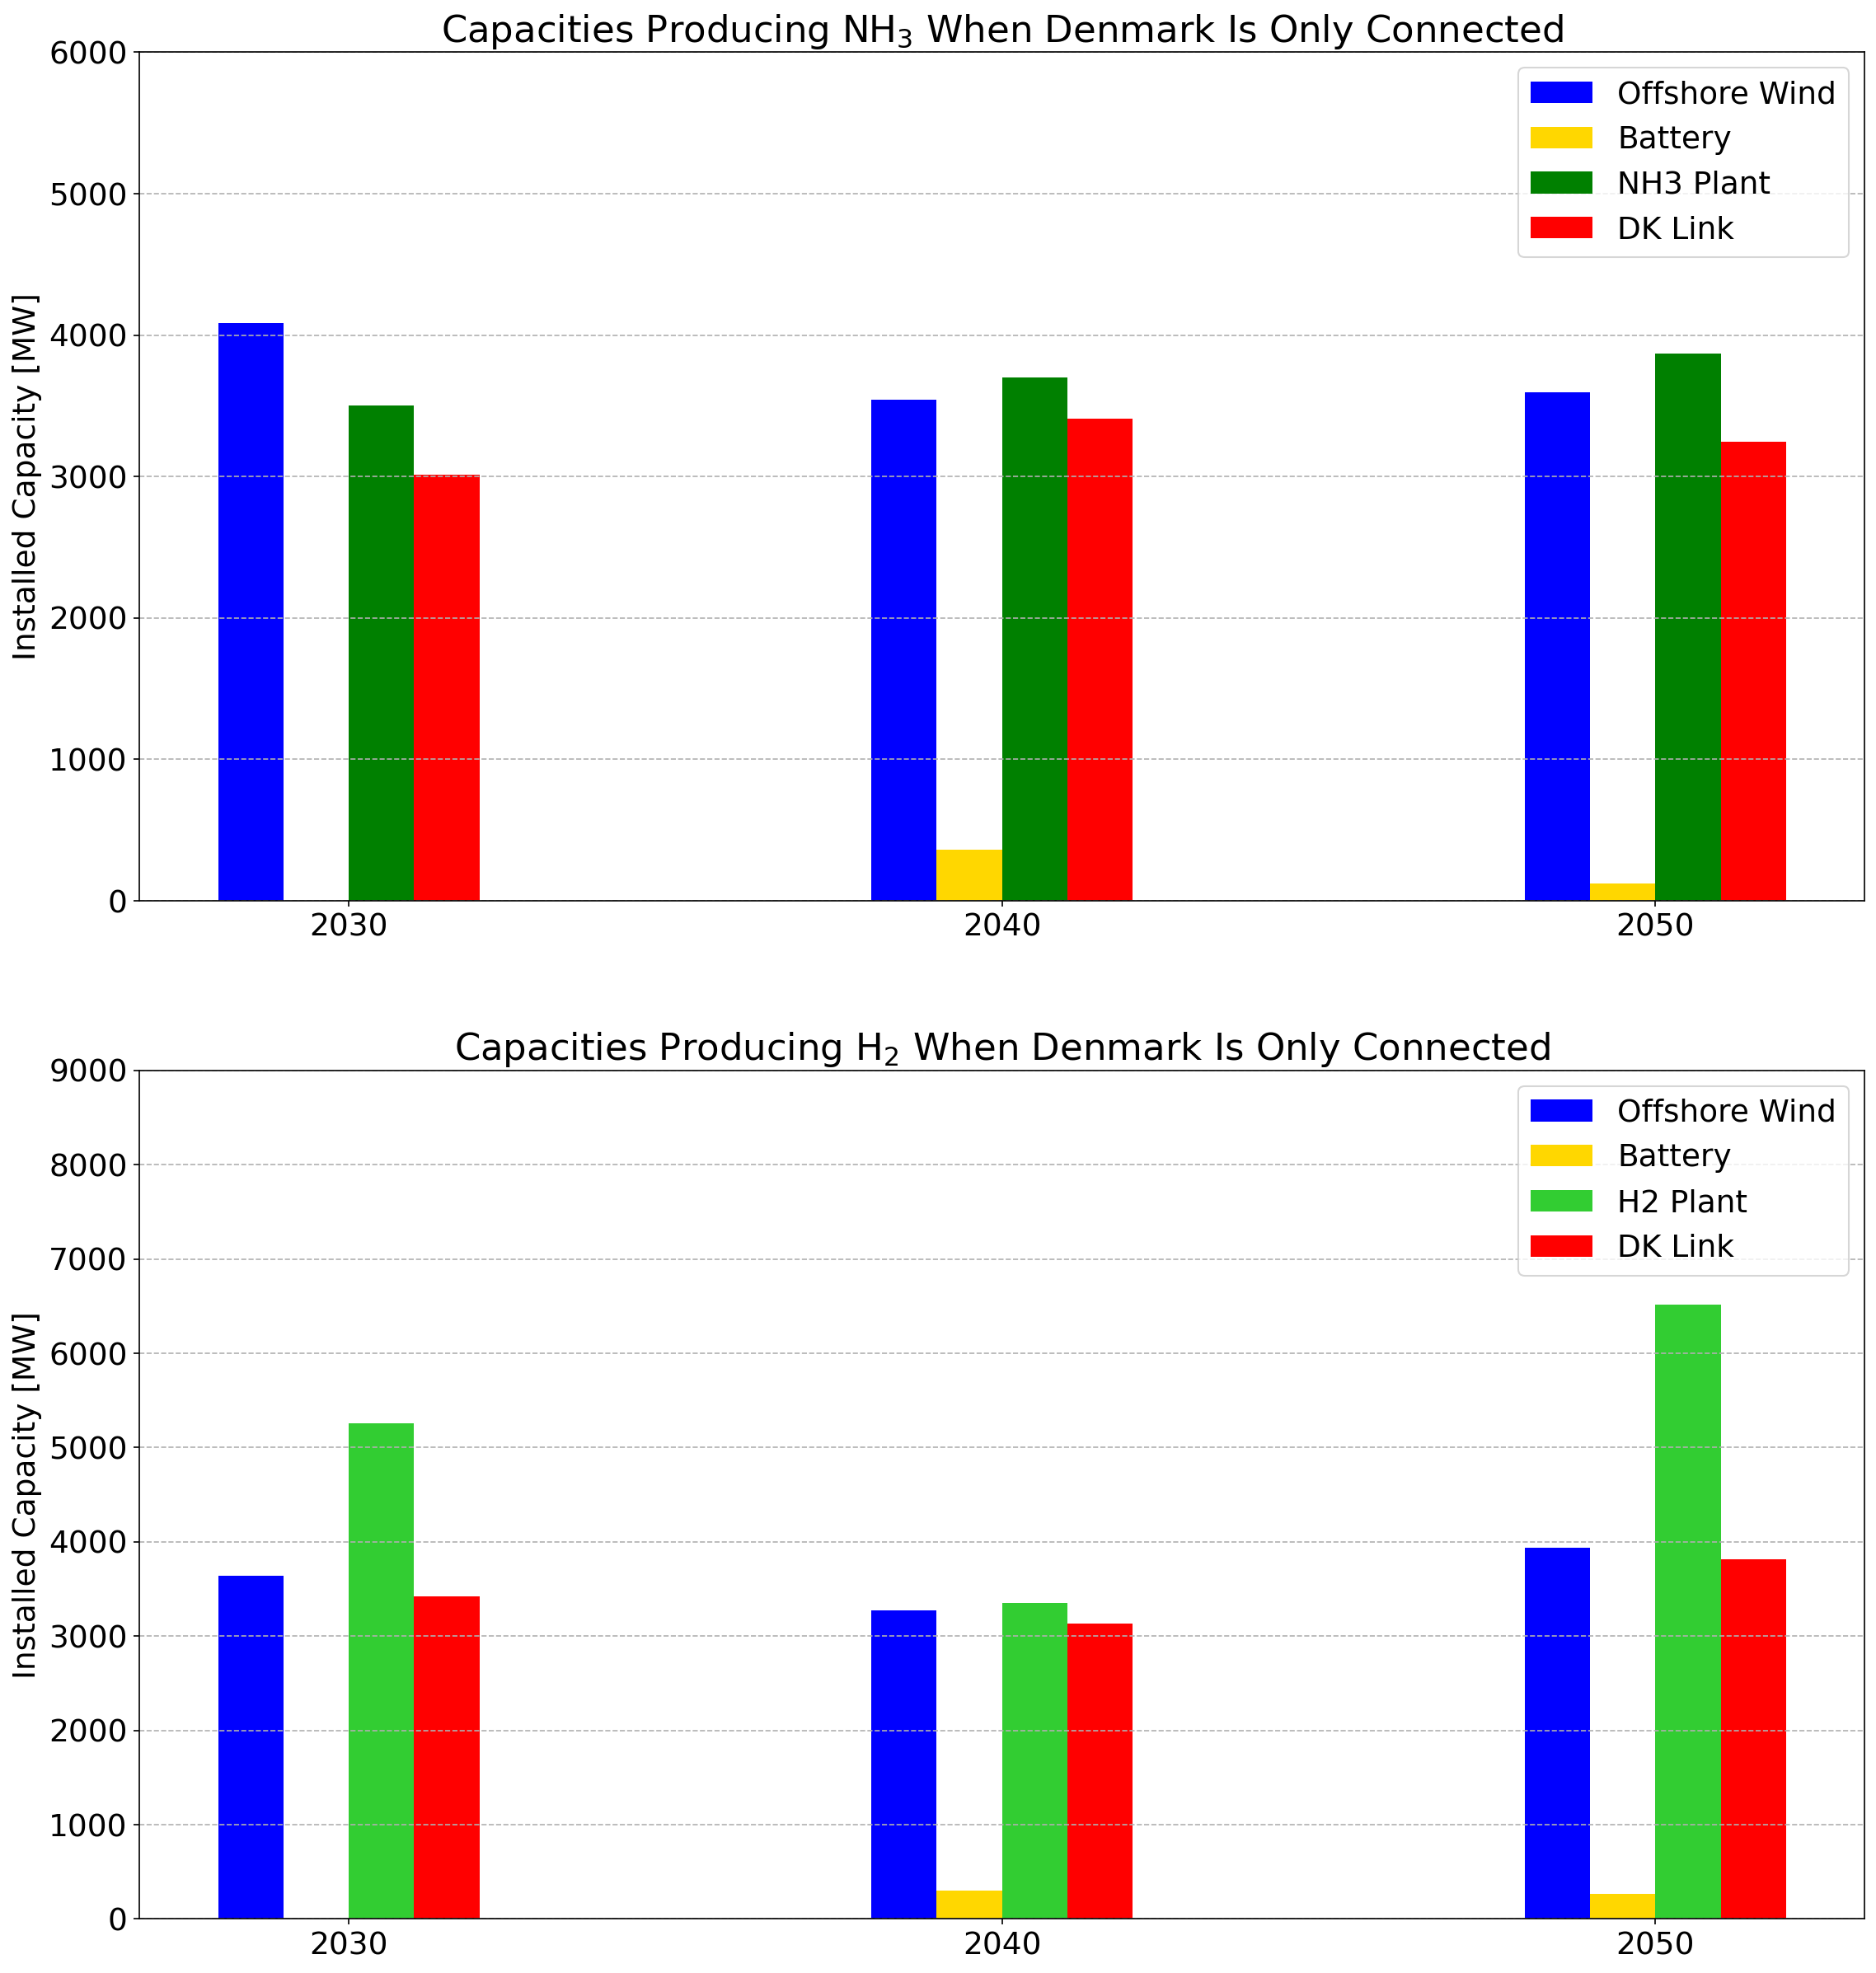

In [18]:
capacities = get_bar_capacities('10000') # only DK connected
colors = ['blue','gold','green','red']

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (18,20), dpi = 150)
x = np.arange(3)
width = 0.1
for i,j in zip(np.arange(len(capacities.index)),capacities.index):
    ax1.bar(x+width*i, capacities.loc[j].filter(regex = r'NH3'), width, color = colors[i],
            label = j if j != 'Fuel Plant' else 'NH3 Plant')
    ax2.bar(x+width*i, capacities.loc[j].filter(regex = r'H2'), width, 
            color = colors[i] if j != 'Fuel Plant' else 'limegreen',
            label = j if j != 'Fuel Plant' else 'H2 Plant')
ax1.set_ylim(0,6000)
ax2.set_ylim(0,9000)
ax1.grid(axis = 'y', linestyle = '--')
ax2.grid(axis = 'y', linestyle = '--')
ax1.set_title(r'Capacities Producing NH$_3$ When Denmark Is Only Connected')
ax2.set_title(r'Capacities Producing H$_2$ When Denmark Is Only Connected')
ax1.set_ylabel('Installed Capacity [MW]')
ax2.set_ylabel('Installed Capacity [MW]')
ax1.set_xticks(x+width*1.5)
ax2.set_xticks(x+width*1.5)
ax1.set_xticklabels([2030,2040,2050])
ax2.set_xticklabels([2030,2040,2050])
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
plt.show()

In [19]:
# correlation between the links
correlation = pd.DataFrame(
    index = [i+'-'+j for i in country for j in country[country.index(i)+1:]],
    columns = [f'{year}_{fuel}' for year in [2030,2040,2050] for fuel in ['H2','NH3']],
    dtype = float
)

for j in correlation.columns:
    temp = locvar[f'network_{j}_11111'].links_t.p0.filter(regex = ' and ')
    for i in correlation.index:
        correlation.loc[i,j] = -temp.filter(regex = i[:2]).squeeze().corr(temp.filter(regex = i[-2:]).squeeze())

print(correlation)

        2030_H2  2030_NH3   2040_H2  2040_NH3   2050_H2  2050_NH3
DK-DE  0.088825  0.203207 -0.268992 -0.244243 -0.065196  0.052629
DK-NO  0.578501  0.430887  0.517517  0.499941  0.431879  0.412489
DK-NL -0.019092  0.073707 -0.004707  0.019469 -0.033685  0.181798
DK-GB  0.211961  0.254368  0.261166  0.270621  0.011067  0.200422
DE-NO  0.044821  0.056835  0.567341  0.564309  0.551286  0.481587
DE-NL -0.475922 -0.388810 -0.453891 -0.464981 -0.553760 -0.611877
DE-GB -0.148238 -0.145127 -0.045062 -0.057471 -0.073070  0.003011
NO-NL  0.324566  0.352862  0.626456  0.604239  0.534772  0.523227
NO-GB -0.032593  0.001904  0.235430  0.211190  0.184021  0.131199
NL-GB -0.290130 -0.250085 -0.422352 -0.420500 -0.341473 -0.287559
